In [1]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import optuna
from optuna import Trial

SEED = 42
n_splits = 5
common_path = '/kaggle/input/child-mind-institute-problematic-internet-use'

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

def process_file(filename, dirname):
    try:
        df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
        df.drop('step', axis=1, inplace=True)
        return df.describe().values.reshape(-1), filename.split('=')[1]
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None, None

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def update_categorical_columns(df, cat_columns):
    for col in cat_columns:
        df[col] = df[col].fillna('Missing').astype('category')
    return df

def create_mapping(column, train, test):
    combined_data = pd.concat([train[column], test[column]], axis=0)
    unique_values = combined_data.unique()
    return {value: idx for idx, value in enumerate(unique_values)}

def apply_mapping(df, mapping, column):
    df[column] = df[column].replace(mapping).astype(int)
    return df

def drop_null_and_constant_columns(train, test):
    null_columns_train = train.columns[train.isnull().all()].tolist()
    constant_columns_train = [col for col in train.columns if train[col].nunique() <= 1]
    
    columns_to_drop = list(set(null_columns_train + constant_columns_train))
    
    train_reduced = train.drop(columns=columns_to_drop)
    test_reduced = test.drop(columns=columns_to_drop)
    
    print(f"Removed columns: {columns_to_drop}")
    return train_reduced, test_reduced, columns_to_drop


# Applying Operations now
train = pd.read_csv(os.path.join(common_path,'train.csv'))
test = pd.read_csv(os.path.join(common_path,'test.csv'))
sample = pd.read_csv(os.path.join(common_path,'sample_submission.csv'))

train_ts = load_time_series(os.path.join(common_path,'series_train.parquet'))
test_ts = load_time_series(os.path.join(common_path,'series_test.parquet'))

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# List of columns
featuresCols_train = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                      'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                      'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                      'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                      'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                      'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                      'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                      'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                      'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                      'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                      'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                      'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                      'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                      'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                      'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                      'PreInt_EduHx-computerinternet_hoursday', 'sii'] + time_series_cols

featuresCols_test = [col for col in featuresCols_train if col != 'sii']

train = train[featuresCols_train]
test = test[featuresCols_test]

cat_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season',
               'Physical-Season', 'Fitness_Endurance-Season', 
               'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
               'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train = update_categorical_columns(train, cat_columns)
test = update_categorical_columns(test, cat_columns)

for col in cat_columns:
    mapping = create_mapping(col, train, test)
    train = apply_mapping(train, mapping, col)
    test = apply_mapping(test, mapping, col)

train, test, removed_columns = drop_null_and_constant_columns(train, test)

print(f'Train Shape: {train.shape} || Test Shape: {test.shape}')


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

Removed columns: ['Stat_42', 'Stat_41']
Train Shape: (3960, 153) || Test Shape: (20, 152)


<Figure size 1200x800 with 0 Axes>

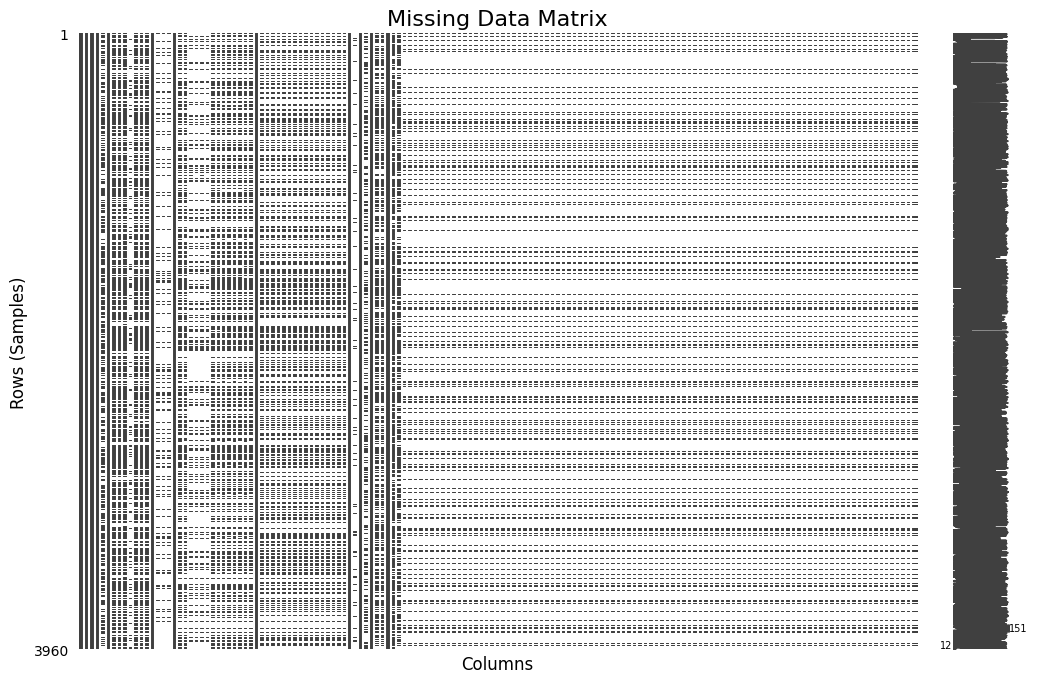

In [2]:
plt.figure(figsize=(12, 8))
msno.matrix(train, figsize=(12, 8), fontsize=8)
plt.title('Missing Data Matrix', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows (Samples)', fontsize=12)
plt.show()

In [3]:
missing_sii_records = train[train['sii'].isnull()]
available_sii_records = train[train['sii'].notnull()]

Proceeding with Supervised Learning...


Training Folds:  20%|██        | 1/5 [00:04<00:18,  4.50s/it]

Fold 1 - Train QWK: 0.8193, Validation QWK: 0.3644


Training Folds:  40%|████      | 2/5 [00:09<00:13,  4.55s/it]

Fold 2 - Train QWK: 0.8214, Validation QWK: 0.4532


Training Folds:  60%|██████    | 3/5 [00:13<00:08,  4.43s/it]

Fold 3 - Train QWK: 0.8238, Validation QWK: 0.4013


Training Folds:  80%|████████  | 4/5 [00:18<00:04,  4.89s/it]

Fold 4 - Train QWK: 0.8312, Validation QWK: 0.3586


Training Folds: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]

Fold 5 - Train QWK: 0.8273, Validation QWK: 0.3939


Plotting top 100 features by importance...


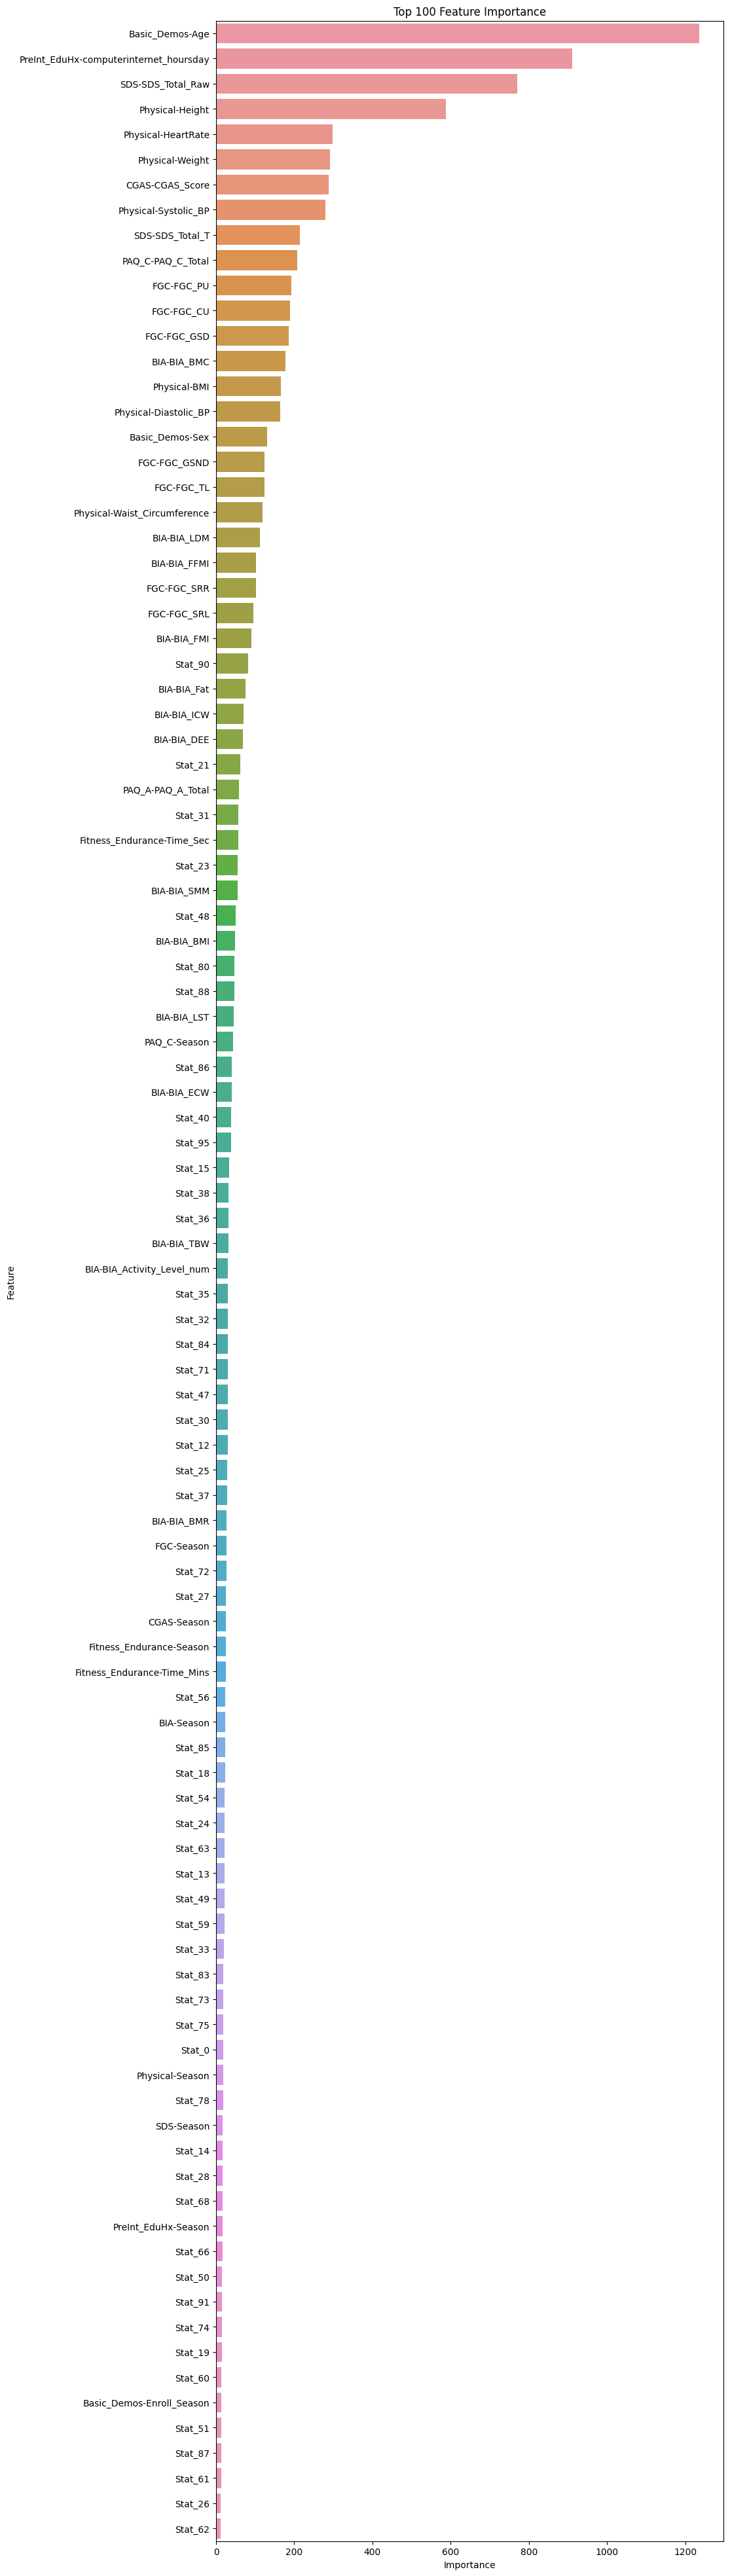

In [4]:
SEED = 42
n_splits = 5

def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculates the quadratic weighted kappa score between true and predicted values.
    
    Quadratic weighted kappa measures the agreement between two sets of ordinal labels 
    by penalizing larger disagreements more heavily.

    Parameters:
    y_true (array-like): Ground truth (correct) target values.
    y_pred (array-like): Predicted target values.

    Returns:
    float: The quadratic weighted kappa score.
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    """
    Rounds the predicted values based on the provided threshold values.
    
    This function applies thresholds to convert continuous model predictions 
    into discrete class labels. It uses the given thresholds to assign class labels 
    to each prediction based on its value.

    Parameters:
    oof_non_rounded (array-like): Continuous predictions made by the model.
    thresholds (array-like): Thresholds for rounding the predictions into class labels.

    Returns:
    array-like: Rounded class labels.
    """
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluates the model predictions by rounding them using the provided thresholds 
    and computing the negative quadratic weighted kappa score.
    
    This function is typically used as a part of an optimization process 
    (like `scipy.optimize.minimize`) to find the best thresholds that maximize the QWK score.

    Parameters:
    thresholds (array-like): Thresholds for rounding predictions into class labels.
    y_true (array-like): Ground truth (correct) target values.
    oof_non_rounded (array-like): Continuous predictions made by the model.

    Returns:
    float: Negative quadratic weighted kappa score (for minimization purposes).
    """
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, X_train, y_train, X_test):
    """
    Trains a model using Stratified K-Fold cross-validation and returns the final predictions.
    
    This function trains a given machine learning model using stratified K-fold cross-validation.
    It evaluates the model on each fold and calculates the quadratic weighted kappa score 
    for both training and validation sets. The function also optimizes the rounding thresholds 
    to improve the kappa score and returns the final predictions.

    Parameters:
    model_class (estimator): A scikit-learn compatible machine learning model (e.g., LightGBM, CatBoost).
    X_train (pd.DataFrame or np.ndarray): Training feature set.
    y_train (pd.Series or np.ndarray): Target variable for training.
    X_test (pd.DataFrame or np.ndarray): Test feature set for final predictions.

    Returns:
    np.ndarray: Tuned predictions for the test set.
    estimator: The trained machine learning model.
    """
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    oof_rounded = np.zeros(len(y_train), dtype=int)
    test_preds = np.zeros((len(X_test), n_splits))
    
    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc="Training Folds", total=n_splits)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = model_class
        model.fit(X_tr, y_tr)

        y_train_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        oof_non_rounded[val_idx] = y_val_pred
        oof_rounded[val_idx] = y_val_pred.round(0).astype(int)
        test_preds[:, fold] = model.predict(X_test)

        train_kappa = quadratic_weighted_kappa(y_tr, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))

        print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tpTuned, model

# Function to plot feature importance
def plot_feature_importance(model, top_n=100):
    """
    Plots the top `top_n` feature importances for the trained LightGBM model.
    
    Parameters:
    model (LightGBM model): The trained LightGBM model.
    top_n (int): Number of top important features to display.
    """
    feature_importance_df = pd.DataFrame({
        'Feature': model.booster_.feature_name(),
        'Importance': model.booster_.feature_importance(importance_type='gain')
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, top_n / 2))  # Adjusting height to accommodate top N features
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n)) 
    plt.title(f"Top {top_n} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    return feature_importance_df

# Create a function to allow supervised or semi-supervised learning and plot feature importance
def supervised_or_semi_supervised(approach='semi-supervised', model_params=None, top_n=100):
    """
    This function allows you to approach the task using supervised or semi-supervised learning,
    and then plots the feature importance.

    Parameters:
    approach (str): "supervised" or "semi-supervised". Default is "semi-supervised".
    model_params (dict): Parameters for the LightGBM model.
    top_n (int): Number of top important features to display in the feature importance plot.
    
    Returns:
    None: Trains the model, plots feature importance, and creates a submission file.
    """
    # Default LightGBM model parameters if none are provided
    if model_params is None:
        model_params = {
            'learning_rate': 0.03884249148676395, 
            'max_depth': 12, 
            'num_leaves': 413, 
            'min_data_in_leaf': 14,
            'feature_fraction': 0.7987976913702801, 
            'bagging_fraction': 0.7602261703576205, 
            'bagging_freq': 2, 
            'lambda_l1': 4.735462555910575, 
            'lambda_l2': 4.735028557007343e-06,
            'n_estimators': 200,
            'random_state': SEED,
            'verbose': -1
        }
    
    Light = lgb.LGBMRegressor(**model_params)

    # Step 1: Split the available and missing sii records
    available_sii_records = train[train['sii'].notnull()].copy()
    missing_sii_records = train[train['sii'].isnull()].copy()

    X_train_avail = available_sii_records.drop('sii', axis=1)
    y_train_avail = available_sii_records['sii']

    # Semi-Supervised Approach
    if approach == 'semi-supervised' and len(missing_sii_records) > 0:
        print("Proceeding with Semi-Supervised Learning...")
        
        # Step 2: Train model on available sii data and predict missing sii values
        X_train_missing = missing_sii_records.drop('sii', axis=1)
        predicted_sii_for_missing, _ = TrainML(Light, X_train_avail, y_train_avail, X_train_missing)

        # Step 3: Combine the predicted `sii` records with the available records
        missing_sii_records['sii'] = predicted_sii_for_missing
        combined_train = pd.concat([available_sii_records, missing_sii_records], axis=0)

        X_train_combined = combined_train.drop('sii', axis=1)
        y_train_combined = combined_train['sii']

        # Step 4: Retrain the model on the combined dataset
        final_preds, final_model = TrainML(Light, X_train_combined, y_train_combined, test)
    
    # Supervised Approach
    else:
        print("Proceeding with Supervised Learning...")
        
        # Step 2: Proceed with supervised learning on the available `sii` data
        final_preds, final_model = TrainML(Light, X_train_avail, y_train_avail, test)

    # Step 5: Plot feature importance
    print(f"Plotting top {top_n} features by importance...")
    feature_importance = plot_feature_importance(final_model, top_n=top_n)

    # Step 6: Prepare the submission
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': final_preds
    })
    
    return submission, feature_importance

submission, feature_importance = supervised_or_semi_supervised(approach='supervised')
submission.to_csv('submission.csv', index=False)

Proceeding with Supervised Learning...


Training Folds:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

Fold 1 - Train QWK: 0.8193, Validation QWK: 0.3644


Training Folds:  40%|████      | 2/5 [00:06<00:09,  3.21s/it]

Fold 2 - Train QWK: 0.8214, Validation QWK: 0.4532


Training Folds:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

Fold 3 - Train QWK: 0.8238, Validation QWK: 0.4013


Training Folds:  80%|████████  | 4/5 [00:12<00:03,  3.21s/it]

Fold 4 - Train QWK: 0.8312, Validation QWK: 0.3586


Training Folds: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

Fold 5 - Train QWK: 0.8273, Validation QWK: 0.3939


Plotting top 100 features by importance...


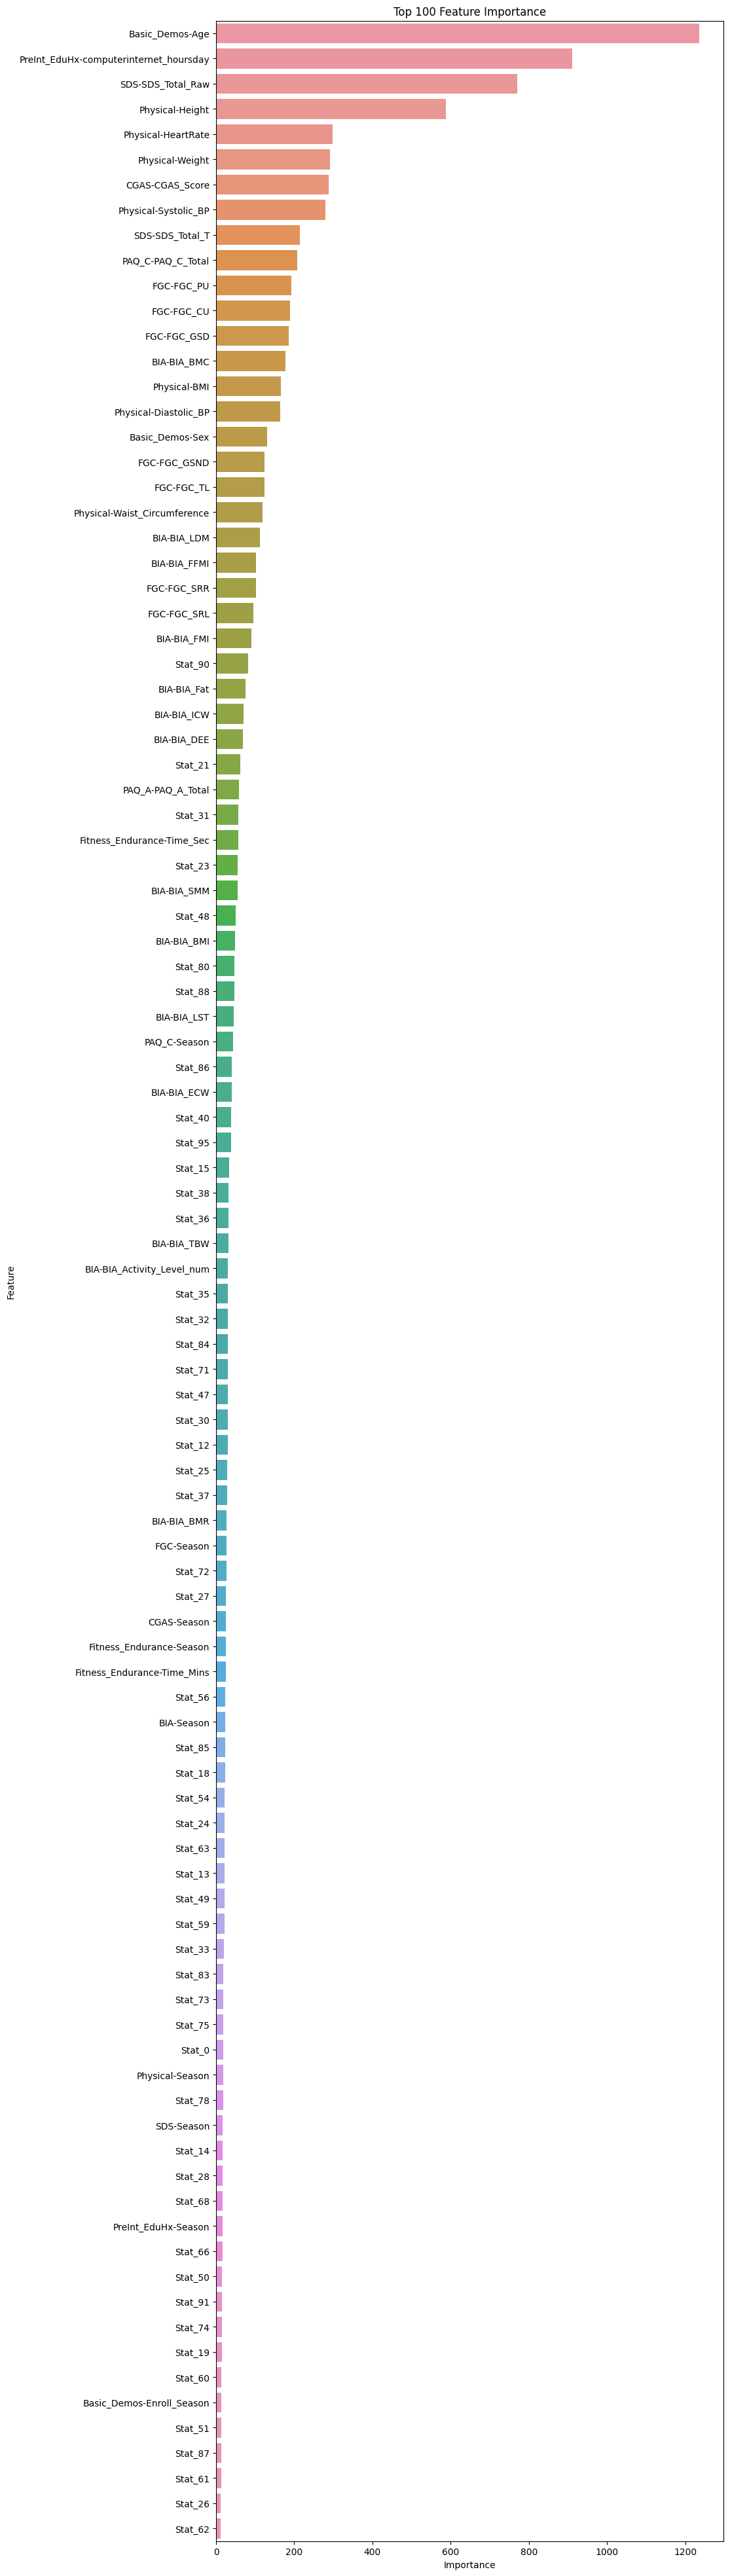

In [5]:
submission, feature_importance = supervised_or_semi_supervised(approach='supervised')
submission.to_csv('submission.csv', index=False)

In [6]:
important_features = [
    'Basic_Demos-Age',
    'PreInt_EduHx-computerinternet_hoursday',
    'SDS-SDS_Total_Raw',
    'Physical-Height',
    'Physical-HeartRate',
    'Physical-Weight',
    'CGAS-CGAS_Score',
    'Physical-Systolic_BP',
    'SDS-SDS_Total_T',
    'PAQ_C-PAQ_C_Total',
    'FGC-FGC_PU',
    'FGC-FGC_CU',
    'FGC-FGC_GSD',
    'BIA-BIA_BMC',
    'Physical-BMI',
    'Physical-Diastolic_BP',
    'Basic_Demos-Sex',
    'FGC-FGC_GSND',
    'FGC-FGC_TL',
    'Physical-Waist_Circumference',
    'BIA-BIA_LDM',
    'BIA-BIA_FFMI',
    'FGC-FGC_SRR'
]

missing_percentage = available_sii_records[important_features].isnull().mean() * 100

missing_df = pd.DataFrame({'Feature': important_features, 'Missing_Percentage': missing_percentage}).reset_index(drop=True)

missing_df

,Feature,Missing_Percentage
0,Basic_Demos-Age,0.000000
1,PreInt_EduHx-computerinternet_hoursday,2.997076
2,SDS-SDS_Total_Raw,7.638889
3,Physical-Height,7.529240
4,Physical-HeartRate,9.137427
5,Physical-Weight,5.994152
6,CGAS-CGAS_Score,14.400585
7,Physical-Systolic_BP,9.429825
8,SDS-SDS_Total_T,7.711988
9,PAQ_C-PAQ_C_Total,47.368421


In [7]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

SEED = 42
n_splits = 5

# Selected features (based on feature importance ranking)
selected_features = [
    'Basic_Demos-Age', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw',
    'Physical-Height', 'Physical-HeartRate', 'Physical-Weight', 'CGAS-CGAS_Score',
    'Physical-Systolic_BP', 'SDS-SDS_Total_T', 'PAQ_C-PAQ_C_Total', 'FGC-FGC_PU',
    'FGC-FGC_CU', 'FGC-FGC_GSD', 'BIA-BIA_BMC', 'Physical-BMI', 'Physical-Diastolic_BP',
    'Basic_Demos-Sex', 'FGC-FGC_GSND', 'FGC-FGC_TL', 'Physical-Waist_Circumference',
    'BIA-BIA_LDM', 'BIA-BIA_FFMI', 'FGC-FGC_SRR'
]

# Evaluation metric: Quadratic Weighted Kappa
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Threshold rounding function
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

# Evaluate predictions based on thresholds
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Training with Stratified K-Fold Cross Validation
def TrainML(model_class, X_train, y_train, X_test):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    test_preds = np.zeros((len(X_test), n_splits))
    
    val_scores = []  # To store QWK score for each fold

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc="Training Folds", total=n_splits)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = model_class
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        oof_non_rounded[val_idx] = y_val_pred
        test_preds[:, fold] = model.predict(X_test)

        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))
        val_scores.append(val_kappa)  # Store validation QWK score
        print(f"Fold {fold + 1} - Validation QWK: {val_kappa:.4f}")

    avg_val_score = np.mean(val_scores)  # Average QWK score across folds
    print(f"Average Validation QWK: {avg_val_score:.4f}")

    # Threshold optimization
    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tpTuned, model, avg_val_score

# Imputation strategies and model training
def train_with_imputation_strategies(train, strategies, k_values=[5]):
    results = []
    
    y_train = train['sii'].dropna()
    X_train = train[selected_features].loc[train['sii'].notnull()]
    
    for strategy in strategies:
        print(f"\nEvaluating with {strategy} imputation strategy")
        
        if strategy == 'no_imputation':
            # No imputation: Use the original data without applying imputation
            X_train_imputed = X_train.copy()
            imputation_description = 'No Imputation'
        elif strategy == 'knn':
            # Evaluate for different k values in KNN
            for k in k_values:
                print(f"Evaluating with KNN Imputation (k={k})")
                imputer = KNNImputer(n_neighbors=k)
                X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
                imputation_description = f'KNN (k={k})'
                # Train the model
                final_preds, final_model, avg_val_score = TrainML(Light, X_train_imputed, y_train, X_train_imputed)
                
                # Log the strategy and final performance
                results.append({
                    'Imputation_Strategy': imputation_description,
                    'Avg_Validation_QWK': avg_val_score
                })
        else:
            # Apply simple imputation strategies ('mean', 'median', 'most_frequent')
            imputer = SimpleImputer(strategy=strategy)
            X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
            imputation_description = strategy.capitalize() + ' Imputation'
        
        if strategy != 'knn':  # For non-KNN strategies
            # Train the model
            final_preds, final_model, avg_val_score = TrainML(Light, X_train_imputed, y_train, X_train_imputed)
            
            # Log the strategy and final performance
            results.append({
                'Imputation_Strategy': imputation_description,
                'Avg_Validation_QWK': avg_val_score
            })
    
    return pd.DataFrame(results)

# Define LightGBM model parameters
model_params = {
    'learning_rate': 0.03884249148676395, 
    'max_depth': 12, 
    'num_leaves': 413, 
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801, 
    'bagging_fraction': 0.7602261703576205, 
    'bagging_freq': 2, 
    'lambda_l1': 4.735462555910575, 
    'lambda_l2': 4.735028557007343e-06,
    'n_estimators': 200,
    'random_state': SEED,
    'verbose': -1
}
Light = lgb.LGBMRegressor(**model_params)

# Example usage with different imputation strategies, including 'no_imputation', 'knn' with multiple k values
strategies = ['no_imputation', 'mean', 'median', 'most_frequent', 'knn']
results_df = train_with_imputation_strategies(train, strategies, k_values=[7, 9, 11, 13, 15, 17])

# Display the results with average validation QWK for each imputation technique
print(results_df)


Evaluating with no_imputation imputation strategy


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.43it/s]

Fold 1 - Validation QWK: 0.3890


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.41it/s]

Fold 2 - Validation QWK: 0.4209


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.38it/s]

Fold 3 - Validation QWK: 0.4044


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.39it/s]

Fold 4 - Validation QWK: 0.3423


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

Fold 5 - Validation QWK: 0.3795
Average Validation QWK: 0.3872



Evaluating with mean imputation strategy


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.06it/s]

Fold 1 - Validation QWK: 0.3702


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.06it/s]

Fold 2 - Validation QWK: 0.4521


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

Fold 3 - Validation QWK: 0.3737


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

Fold 4 - Validation QWK: 0.3443


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

Fold 5 - Validation QWK: 0.3526
Average Validation QWK: 0.3786



Evaluating with median imputation strategy


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.07it/s]

Fold 1 - Validation QWK: 0.3585


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.08it/s]

Fold 2 - Validation QWK: 0.4228


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.07it/s]

Fold 3 - Validation QWK: 0.4129


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

Fold 4 - Validation QWK: 0.3589


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

Fold 5 - Validation QWK: 0.3478
Average Validation QWK: 0.3802



Evaluating with most_frequent imputation strategy


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Fold 1 - Validation QWK: 0.3892


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.91it/s]

Fold 2 - Validation QWK: 0.4258


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Fold 3 - Validation QWK: 0.4273


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]

Fold 4 - Validation QWK: 0.3301


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

Fold 5 - Validation QWK: 0.3573
Average Validation QWK: 0.3859



Evaluating with knn imputation strategy
Evaluating with KNN Imputation (k=7)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Fold 1 - Validation QWK: 0.3774


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

Fold 2 - Validation QWK: 0.4252


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

Fold 3 - Validation QWK: 0.4082


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.78it/s]

Fold 4 - Validation QWK: 0.3588


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

Fold 5 - Validation QWK: 0.4353
Average Validation QWK: 0.4010


Evaluating with KNN Imputation (k=9)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Fold 1 - Validation QWK: 0.3991


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Fold 2 - Validation QWK: 0.4185


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Fold 3 - Validation QWK: 0.4081


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Fold 4 - Validation QWK: 0.3649


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

Fold 5 - Validation QWK: 0.4105
Average Validation QWK: 0.4002


Evaluating with KNN Imputation (k=11)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.71it/s]

Fold 1 - Validation QWK: 0.3793


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.73it/s]

Fold 2 - Validation QWK: 0.3983


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Fold 3 - Validation QWK: 0.3889


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Fold 4 - Validation QWK: 0.3447


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Fold 5 - Validation QWK: 0.3836
Average Validation QWK: 0.3790


Evaluating with KNN Imputation (k=13)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.74it/s]

Fold 1 - Validation QWK: 0.3993


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.71it/s]

Fold 2 - Validation QWK: 0.4221


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.4450


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Fold 4 - Validation QWK: 0.4073


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Fold 5 - Validation QWK: 0.3996
Average Validation QWK: 0.4146


Evaluating with KNN Imputation (k=15)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Fold 1 - Validation QWK: 0.3876


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.69it/s]

Fold 2 - Validation QWK: 0.4425


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Fold 3 - Validation QWK: 0.3961


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Fold 4 - Validation QWK: 0.3813


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Fold 5 - Validation QWK: 0.3824
Average Validation QWK: 0.3980


Evaluating with KNN Imputation (k=17)


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Fold 1 - Validation QWK: 0.3979


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Fold 2 - Validation QWK: 0.4315


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.4298


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Fold 4 - Validation QWK: 0.3777


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

Fold 5 - Validation QWK: 0.3954
Average Validation QWK: 0.4065


        Imputation_Strategy  Avg_Validation_QWK
0             No Imputation            0.387199
1           Mean Imputation            0.378567
2         Median Imputation            0.380185
3  Most_frequent Imputation            0.385936
4                 KNN (k=7)            0.400984
5                 KNN (k=9)            0.400196
6                KNN (k=11)            0.378975
7                KNN (k=13)            0.414640
8                KNN (k=15)            0.397981
9                KNN (k=17)            0.406485


In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from tqdm import tqdm
import warnings
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

SEED = 42
n_splits = 5

# Selected features (based on feature importance ranking)
selected_features = [
    'Basic_Demos-Age', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw',
    'Physical-Height', 'Physical-HeartRate', 'Physical-Weight', 'CGAS-CGAS_Score',
    'Physical-Systolic_BP', 'SDS-SDS_Total_T', 'PAQ_C-PAQ_C_Total', 'FGC-FGC_PU',
    'FGC-FGC_CU', 'FGC-FGC_GSD', 'BIA-BIA_BMC', 'Physical-BMI', 'Physical-Diastolic_BP',
    'Basic_Demos-Sex', 'FGC-FGC_GSND', 'FGC-FGC_TL', 'Physical-Waist_Circumference',
    'BIA-BIA_LDM', 'BIA-BIA_FFMI', 'FGC-FGC_SRR'
]

# To store the hyperparameters and validation scores during Bayesian Optimization
optimization_history = []

# Evaluation metric: Quadratic Weighted Kappa
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Threshold rounding function
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

# Evaluate predictions based on thresholds
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Training with Stratified K-Fold Cross Validation
def TrainML(model_class, X_train, y_train, X_test):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    test_preds = np.zeros((len(X_test), n_splits))
    
    val_scores = []  # To store QWK score for each fold

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc="Training Folds", total=n_splits)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = model_class
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        oof_non_rounded[val_idx] = y_val_pred
        test_preds[:, fold] = model.predict(X_test)

        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))
        val_scores.append(val_kappa)  # Store validation QWK score
        print(f"Fold {fold + 1} - Validation QWK: {val_kappa:.4f}")

    avg_val_score = np.mean(val_scores)  # Average QWK score across folds
    print(f"Average Validation QWK: {avg_val_score:.4f}")

    # Threshold optimization
    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tpTuned, model, avg_val_score

# Objective function for Bayesian Optimization
def bayesian_opt_function(learning_rate, max_depth, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, lambda_l1, lambda_l2, n_estimators):
    # Cast parameters that need to be integers
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),  # Ensure integer
        'num_leaves': int(num_leaves),  # Ensure integer
        'min_data_in_leaf': int(min_data_in_leaf),  # Ensure integer
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),  # Ensure integer
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'n_estimators': int(n_estimators),  # Ensure integer
        'random_state': SEED,
        'verbose': -1
    }
    
    # Initialize the LightGBM model with the updated parameters
    Light = lgb.LGBMRegressor(**params)
    
    # Call the TrainML function to train and evaluate the model
    _, _, avg_val_score = TrainML(Light, X_train_imputed, y_train, X_train_imputed)
    
    # Append the current hyperparameters and validation score to the optimization history
    optimization_history.append({**params, 'Avg_Validation_QWK': avg_val_score})

    return avg_val_score

# Bayesian optimization for LightGBM parameters
def optimize_hyperparameters():
    pbounds = {
        'learning_rate': (0.01, 0.05),
        'max_depth': (6, 15),
        'num_leaves': (100, 500),
        'min_data_in_leaf': (10, 30),
        'feature_fraction': (0.6, 0.9),
        'bagging_fraction': (0.6, 0.9),
        'bagging_freq': (1, 5),
        'lambda_l1': (0.0, 5.0),
        'lambda_l2': (0.0, 5.0),
        'n_estimators': (100, 300),
    }

    optimizer = BayesianOptimization(
        f=bayesian_opt_function,
        pbounds=pbounds,
        random_state=SEED,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=30)
    return optimizer

def train_with_imputation_and_bayesian_opt(train, strategies, k_values=[5]):
    global X_train_imputed, y_train
    results = []
    
    y_train = train['sii'].dropna()
    X_train = train[selected_features].loc[train['sii'].notnull()]
    
    for strategy in strategies:
        print(f"\nEvaluating with {strategy} imputation strategy")
        
        if strategy == 'no_imputation':
            # No imputation: Use the original data without applying imputation
            X_train_imputed = X_train.copy()
            imputation_description = 'No Imputation'
        elif strategy == 'knn':
            # Evaluate for different k values in KNN
            for k in k_values:
                print(f"Evaluating with KNN Imputation (k={k})")
                imputer = KNNImputer(n_neighbors=k)
                X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
                imputation_description = f'KNN (k={k})'
                
                # Perform Bayesian optimization
                optimizer = optimize_hyperparameters()
                best_params = optimizer.max['params']
                
                # Cast `n_estimators` and other integer-based hyperparameters
                best_params['n_estimators'] = int(best_params['n_estimators'])
                best_params['num_leaves'] = int(best_params['num_leaves'])
                best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
                best_params['max_depth'] = int(best_params['max_depth'])
                best_params['bagging_freq'] = int(best_params['bagging_freq'])

                # Train with best hyperparameters
                Light = lgb.LGBMRegressor(**best_params)
                final_preds, final_model, avg_val_score = TrainML(Light, X_train_imputed, y_train, X_train_imputed)

                # Log the strategy, hyperparams, and final performance
                results.append({
                    'Imputation_Strategy': imputation_description,
                    'Hyperparameters': best_params,
                    'Avg_Validation_QWK': avg_val_score
                })
        else:
            # Apply simple imputation strategies ('mean', 'median', 'most_frequent')
            imputer = SimpleImputer(strategy=strategy)
            X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
            imputation_description = strategy.capitalize() + ' Imputation'
            
            # Perform Bayesian optimization
            optimizer = optimize_hyperparameters()
            best_params = optimizer.max['params']
            
            # Cast `n_estimators` and other integer-based hyperparameters
            best_params['n_estimators'] = int(best_params['n_estimators'])
            best_params['num_leaves'] = int(best_params['num_leaves'])
            best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
            best_params['max_depth'] = int(best_params['max_depth'])
            best_params['bagging_freq'] = int(best_params['bagging_freq'])

            # Train with best hyperparameters
            Light = lgb.LGBMRegressor(**best_params)
            final_preds, final_model, avg_val_score = TrainML(Light, X_train_imputed, y_train, X_train_imputed)

            # Log the strategy, hyperparams, and final performance
            results.append({
                'Imputation_Strategy': imputation_description,
                'Hyperparameters': best_params,
                'Avg_Validation_QWK': avg_val_score
            })
    
    return pd.DataFrame(results)

# Example usage with different imputation strategies, including 'no_imputation', 'knn' with multiple k values
strategies = ['no_imputation', 'mean', 'median', 'most_frequent', 'knn']
results_df = train_with_imputation_and_bayesian_opt(train, strategies, k_values=[7, 9, 11, 13, 15])

# Display the results with average validation QWK for each imputation technique and hyperparameter combination
print(results_df)
results_df.to_csv('imputation_hyperparameter_results.csv', index=False)


Evaluating with no_imputation imputation strategy

Evaluating with mean imputation strategy
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.83it/s]

Fold 1 - Validation QWK: 0.3232


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.91it/s]

Fold 2 - Validation QWK: 0.4459


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.91it/s]

Fold 3 - Validation QWK: 0.3730


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

Fold 4 - Validation QWK: 0.3422


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

Fold 5 - Validation QWK: 0.3636
Average Validation QWK: 0.3696


| 1         | 0.3696    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3337


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.46it/s]

Fold 2 - Validation QWK: 0.4072


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

Fold 3 - Validation QWK: 0.3593


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.56it/s]

Fold 4 - Validation QWK: 0.3502


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

Fold 5 - Validation QWK: 0.3597
Average Validation QWK: 0.3620


| 2         | 0.362     | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Fold 1 - Validation QWK: 0.3724


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.75it/s]

Fold 2 - Validation QWK: 0.4211


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

Fold 3 - Validation QWK: 0.3855


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.75it/s]

Fold 4 - Validation QWK: 0.3414


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

Fold 5 - Validation QWK: 0.3732
Average Validation QWK: 0.3787


| 3         | 0.3787    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3666


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.31it/s]

Fold 2 - Validation QWK: 0.4206


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.28it/s]

Fold 3 - Validation QWK: 0.3752


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

Fold 4 - Validation QWK: 0.3524


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Fold 5 - Validation QWK: 0.3885
Average Validation QWK: 0.3807


| 4         | 0.3807    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.04it/s]

Fold 1 - Validation QWK: 0.3716


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.00it/s]

Fold 2 - Validation QWK: 0.4463


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.97it/s]

Fold 3 - Validation QWK: 0.3865


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.98it/s]

Fold 4 - Validation QWK: 0.3791


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

Fold 5 - Validation QWK: 0.3659
Average Validation QWK: 0.3899


| 5         | 0.3899    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.29it/s]

Fold 1 - Validation QWK: 0.3782


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.29it/s]

Fold 2 - Validation QWK: 0.4249


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

Fold 3 - Validation QWK: 0.3635


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

Fold 4 - Validation QWK: 0.3421


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

Fold 5 - Validation QWK: 0.3479
Average Validation QWK: 0.3713


| 6         | 0.3713    | 0.7101    | 4.711     | 0.8434    | 1.653     | 2.738     | 0.02624   | 10.2      | 25.22     | 208.6     | 172.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

Fold 1 - Validation QWK: 0.3586


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.4381


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.54it/s]

Fold 3 - Validation QWK: 0.3855


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

Fold 4 - Validation QWK: 0.3663


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

Fold 5 - Validation QWK: 0.3566
Average Validation QWK: 0.3810


| 7         | 0.381     | 0.6233    | 2.193     | 0.6251    | 2.136     | 2.416     | 0.02424   | 7.61      | 17.37     | 238.0     | 149.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.34it/s]

Fold 1 - Validation QWK: 0.3460


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.33it/s]

Fold 2 - Validation QWK: 0.3952


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.32it/s]

Fold 3 - Validation QWK: 0.3583


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

Fold 4 - Validation QWK: 0.3180


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

Fold 5 - Validation QWK: 0.3498
Average Validation QWK: 0.3535


| 8         | 0.3535    | 0.6348    | 3.506     | 0.6065    | 4.376     | 3.158     | 0.01125   | 12.93     | 22.35     | 291.1     | 204.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.38it/s]

Fold 1 - Validation QWK: 0.3650


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.44it/s]

Fold 2 - Validation QWK: 0.4292


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.43it/s]

Fold 3 - Validation QWK: 0.3728


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

Fold 4 - Validation QWK: 0.3671


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

Fold 5 - Validation QWK: 0.4035
Average Validation QWK: 0.3875


| 9         | 0.3875    | 0.879     | 4.296     | 0.7292    | 3.074     | 4.425     | 0.0238    | 6.718     | 16.38     | 226.9     | 406.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Fold 1 - Validation QWK: 0.3802


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.20it/s]

Fold 2 - Validation QWK: 0.4301


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Fold 3 - Validation QWK: 0.3741


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

Fold 4 - Validation QWK: 0.3791


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

Fold 5 - Validation QWK: 0.3959
Average Validation QWK: 0.3919


| 10        | 0.3919    | 0.7958    | 3.555     | 0.8751    | 4.689     | 2.231     | 0.02468   | 12.41     | 17.13     | 192.7     | 245.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.57it/s]

Fold 1 - Validation QWK: 0.3375


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.56it/s]

Fold 2 - Validation QWK: 0.4174


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.55it/s]

Fold 3 - Validation QWK: 0.3823


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

Fold 4 - Validation QWK: 0.3257


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

Fold 5 - Validation QWK: 0.3498
Average Validation QWK: 0.3625


| 11        | 0.3625    | 0.6229    | 3.219     | 0.7841    | 4.157     | 4.579     | 0.01388   | 10.92     | 27.3      | 258.0     | 129.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.22it/s]

Fold 1 - Validation QWK: 0.3525


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.30it/s]

Fold 2 - Validation QWK: 0.4245


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.31it/s]

Fold 3 - Validation QWK: 0.3768


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.33it/s]

Fold 4 - Validation QWK: 0.3333


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Fold 5 - Validation QWK: 0.3728
Average Validation QWK: 0.3720


| 12        | 0.372     | 0.8231    | 4.107     | 0.6943    | 3.201     | 2.083     | 0.02612   | 9.12      | 17.42     | 129.9     | 280.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.89it/s]

Fold 1 - Validation QWK: 0.3360


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.84it/s]

Fold 2 - Validation QWK: 0.4391


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

Fold 3 - Validation QWK: 0.3852


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Fold 4 - Validation QWK: 0.3588


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

Fold 5 - Validation QWK: 0.3552
Average Validation QWK: 0.3749


| 13        | 0.3749    | 0.7007    | 4.416     | 0.8487    | 2.381     | 3.302     | 0.01415   | 7.205     | 16.4      | 271.9     | 196.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.88it/s]

Fold 1 - Validation QWK: 0.3703


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.69it/s]

Fold 2 - Validation QWK: 0.4123


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.57it/s]

Fold 3 - Validation QWK: 0.4005


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

Fold 4 - Validation QWK: 0.3562


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

Fold 5 - Validation QWK: 0.3448
Average Validation QWK: 0.3768


| 14        | 0.3768    | 0.6325    | 1.342     | 0.8621    | 4.226     | 3.13      | 0.03161   | 12.9      | 27.4      | 290.5     | 481.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]

Fold 1 - Validation QWK: 0.3559


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.97it/s]

Fold 2 - Validation QWK: 0.4184


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.92it/s]

Fold 3 - Validation QWK: 0.3779


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.91it/s]

Fold 4 - Validation QWK: 0.3463


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

Fold 5 - Validation QWK: 0.3830
Average Validation QWK: 0.3763


| 15        | 0.3763    | 0.6744    | 3.712     | 0.6005    | 0.4791    | 2.507     | 0.01683   | 7.267     | 25.43     | 213.4     | 120.3     |


Training Folds:  40%|████      | 2/5 [00:00<00:00,  5.04it/s]

Fold 1 - Validation QWK: 0.3501
Fold 2 - Validation QWK: 0.4322


Training Folds:  80%|████████  | 4/5 [00:00<00:00,  5.02it/s]

Fold 3 - Validation QWK: 0.3683
Fold 4 - Validation QWK: 0.3374


Training Folds: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Fold 5 - Validation QWK: 0.3444
Average Validation QWK: 0.3665
| 16        | 0.3665    | 0.6688    | 1.821     | 0.6258    | 3.362     | 0.3699    | 0.04837   | 10.28     | 19.2      | 104.9     | 412.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.63it/s]

Fold 1 - Validation QWK: 0.3535


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.68it/s]

Fold 2 - Validation QWK: 0.4346


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.68it/s]

Fold 3 - Validation QWK: 0.3732


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.65it/s]

Fold 4 - Validation QWK: 0.3508


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

Fold 5 - Validation QWK: 0.3731
Average Validation QWK: 0.3771


| 17        | 0.3771    | 0.623     | 1.053     | 0.8337    | 4.216     | 0.7794    | 0.03196   | 10.79     | 15.11     | 130.4     | 319.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Fold 1 - Validation QWK: 0.3535


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Fold 2 - Validation QWK: 0.4190


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.3745


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Fold 4 - Validation QWK: 0.3607


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

Fold 5 - Validation QWK: 0.3599
Average Validation QWK: 0.3735


| 18        | 0.3735    | 0.8371    | 2.461     | 0.6738    | 0.7364    | 4.536     | 0.01704   | 13.09     | 23.81     | 232.0     | 359.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.10it/s]

Fold 1 - Validation QWK: 0.3379


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.11it/s]

Fold 2 - Validation QWK: 0.4216


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.09it/s]

Fold 3 - Validation QWK: 0.3966


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.08it/s]

Fold 4 - Validation QWK: 0.3352


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

Fold 5 - Validation QWK: 0.3730
Average Validation QWK: 0.3728


| 19        | 0.3728    | 0.7145    | 2.651     | 0.7453    | 4.212     | 2.761     | 0.02285   | 6.69      | 12.09     | 180.6     | 311.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.62it/s]

Fold 1 - Validation QWK: 0.3985


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Fold 2 - Validation QWK: 0.4183


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.50it/s]

Fold 3 - Validation QWK: 0.3928


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Fold 4 - Validation QWK: 0.3706


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Fold 5 - Validation QWK: 0.3480
Average Validation QWK: 0.3856


| 20        | 0.3856    | 0.7703    | 4.404     | 0.7775    | 2.095     | 1.27      | 0.03116   | 7.255     | 11.93     | 291.5     | 119.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.35it/s]

Fold 1 - Validation QWK: 0.3814


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Fold 2 - Validation QWK: 0.4161


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

Fold 3 - Validation QWK: 0.3957


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.33it/s]

Fold 4 - Validation QWK: 0.3545


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

Fold 5 - Validation QWK: 0.3495
Average Validation QWK: 0.3794


| 21        | 0.3794    | 0.8771    | 1.012     | 0.7476    | 3.766     | 0.5551    | 0.03336   | 14.34     | 13.13     | 275.3     | 452.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.07it/s]

Fold 1 - Validation QWK: 0.3700


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.07it/s]

Fold 2 - Validation QWK: 0.4095


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Validation QWK: 0.4035


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Fold 4 - Validation QWK: 0.3486


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

Fold 5 - Validation QWK: 0.3569
Average Validation QWK: 0.3777


| 22        | 0.3777    | 0.8133    | 3.572     | 0.8926    | 4.706     | 2.248     | 0.04221   | 12.43     | 17.15     | 192.7     | 245.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.41it/s]

Fold 1 - Validation QWK: 0.3262


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.34it/s]

Fold 2 - Validation QWK: 0.4249


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.41it/s]

Fold 3 - Validation QWK: 0.3634


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

Fold 4 - Validation QWK: 0.3479


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

Fold 5 - Validation QWK: 0.3538
Average Validation QWK: 0.3632


| 23        | 0.3632    | 0.7287    | 3.485     | 0.8048    | 4.618     | 2.16      | 0.01805   | 12.34     | 17.06     | 192.6     | 245.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.93it/s]

Fold 1 - Validation QWK: 0.3922


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.92it/s]

Fold 2 - Validation QWK: 0.4261


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

Fold 3 - Validation QWK: 0.3877


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.93it/s]

Fold 4 - Validation QWK: 0.3674


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

Fold 5 - Validation QWK: 0.3638
Average Validation QWK: 0.3875


| 24        | 0.3875    | 0.8283    | 4.698     | 0.8063    | 4.948     | 1.424     | 0.02849   | 7.765     | 20.83     | 275.3     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:01<00:04,  1.04s/it]

Fold 1 - Validation QWK: 0.3930


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.02it/s]

Fold 2 - Validation QWK: 0.3911


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Fold 3 - Validation QWK: 0.3857


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

Fold 4 - Validation QWK: 0.3288


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Fold 5 - Validation QWK: 0.3571
Average Validation QWK: 0.3712


| 25        | 0.3712    | 0.8581    | 1.441     | 0.8312    | 0.04269   | 0.8627    | 0.04719   | 10.49     | 14.33     | 268.8     | 168.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.19it/s]

Fold 1 - Validation QWK: 0.3863


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.18it/s]

Fold 2 - Validation QWK: 0.4281


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.13it/s]

Fold 3 - Validation QWK: 0.4135


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

Fold 4 - Validation QWK: 0.3589


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

Fold 5 - Validation QWK: 0.3932
Average Validation QWK: 0.3960


| 26        | 0.396     | 0.8213    | 2.02      | 0.6259    | 4.629     | 4.573     | 0.04573   | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.27it/s]

Fold 1 - Validation QWK: 0.4066


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.29it/s]

Fold 2 - Validation QWK: 0.3968


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

Fold 3 - Validation QWK: 0.4025


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

Fold 4 - Validation QWK: 0.3104


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Fold 5 - Validation QWK: 0.3467
Average Validation QWK: 0.3726


| 27        | 0.3726    | 0.6683    | 1.474     | 0.8234    | 1.409     | 2.061     | 0.03843   | 12.54     | 15.15     | 288.8     | 448.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.00it/s]

Fold 1 - Validation QWK: 0.3864


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.05it/s]

Fold 2 - Validation QWK: 0.4258


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

Fold 3 - Validation QWK: 0.4045


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

Fold 4 - Validation QWK: 0.3596


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

Fold 5 - Validation QWK: 0.3472
Average Validation QWK: 0.3847


| 28        | 0.3847    | 0.8348    | 2.033     | 0.6393    | 4.643     | 4.587     | 0.05      | 13.34     | 23.83     | 241.1     | 256.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.87it/s]

Fold 1 - Validation QWK: 0.3355


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.86it/s]

Fold 2 - Validation QWK: 0.4157


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Fold 3 - Validation QWK: 0.3747


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.85it/s]

Fold 4 - Validation QWK: 0.3615


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

Fold 5 - Validation QWK: 0.3653
Average Validation QWK: 0.3706


| 29        | 0.3706    | 0.697     | 4.406     | 0.8152    | 0.3914    | 2.891     | 0.01822   | 13.18     | 26.28     | 235.0     | 116.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.12it/s]

Fold 1 - Validation QWK: 0.3897


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.13it/s]

Fold 2 - Validation QWK: 0.4233


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

Fold 3 - Validation QWK: 0.4129


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

Fold 4 - Validation QWK: 0.3796


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

Fold 5 - Validation QWK: 0.3701
Average Validation QWK: 0.3951


| 30        | 0.3951    | 0.8146    | 2.013     | 0.651     | 4.623     | 4.567     | 0.0456    | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.16it/s]

Fold 1 - Validation QWK: 0.3596


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.17it/s]

Fold 2 - Validation QWK: 0.4184


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.17it/s]

Fold 3 - Validation QWK: 0.4240


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

Fold 4 - Validation QWK: 0.3436


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

Fold 5 - Validation QWK: 0.3628
Average Validation QWK: 0.3816


| 31        | 0.3816    | 0.8068    | 2.004     | 0.6077    | 4.614     | 4.558     | 0.04066   | 13.31     | 23.8      | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.16it/s]

Fold 1 - Validation QWK: 0.3798


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.15it/s]

Fold 2 - Validation QWK: 0.4076


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.15it/s]

Fold 3 - Validation QWK: 0.4221


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

Fold 4 - Validation QWK: 0.3486


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

Fold 5 - Validation QWK: 0.3617
Average Validation QWK: 0.3840


| 32        | 0.384     | 0.7863    | 2.022     | 0.6402    | 4.632     | 4.576     | 0.04336   | 13.32     | 23.82     | 241.1     | 256.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.04it/s]

Fold 1 - Validation QWK: 0.3993


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.03it/s]

Fold 2 - Validation QWK: 0.4380


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Fold 3 - Validation QWK: 0.3884


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.03it/s]

Fold 4 - Validation QWK: 0.3468


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

Fold 5 - Validation QWK: 0.3327
Average Validation QWK: 0.3810


| 33        | 0.381     | 0.8507    | 2.013     | 0.6405    | 4.623     | 4.567     | 0.05      | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.16it/s]

Fold 1 - Validation QWK: 0.3445


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.14it/s]

Fold 2 - Validation QWK: 0.4116


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Validation QWK: 0.3604


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Fold 4 - Validation QWK: 0.3384


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

Fold 5 - Validation QWK: 0.3729
Average Validation QWK: 0.3656


| 34        | 0.3656    | 0.8192    | 2.018     | 0.6395    | 4.628     | 4.572     | 0.02042   | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.92it/s]

Fold 1 - Validation QWK: 0.3861


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Fold 2 - Validation QWK: 0.4249


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

Fold 3 - Validation QWK: 0.4031


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.99it/s]

Fold 4 - Validation QWK: 0.3451


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

Fold 5 - Validation QWK: 0.3437
Average Validation QWK: 0.3806


| 35        | 0.3806    | 0.7825    | 2.438     | 0.7946    | 4.674     | 2.1       | 0.02791   | 8.291     | 29.72     | 275.0     | 278.6     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6258635302146006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258635302146006
[LightGBM] [Warning] lambda_l2 is set=4.5734422589243575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5734422589243575
[LightGBM] [Warning] lambda_l1 is set=4.629446642911663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.629446642911663
[LightGBM] [Warning] bagging_fraction is set=0.821294851701706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821294851701706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6258635302146006, colsample_bytree=1.

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.08it/s]

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6258635302146006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258635302146006
[LightGBM] [Warning] lambda_l2 is set=4.5734422589243575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5734422589243575
[LightGBM] [Warning] lambda_l1 is set=4.629446642911663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.629446642911663
[LightGBM] [Warning] bagging_fraction is set=0.821294851701706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821294851701706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Fold 1 - Validation QWK: 0.3815
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.62586

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Validation QWK: 0.3742
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6258635302146006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258635302146006
[LightGBM] [Warning] lambda_l2 is set=4.5734422589243575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5734422589243575
[LightGBM] [Warning] lambda_l1 is set=4.629446642911663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.629446642911663
[LightGBM] [Warning] bagging_fraction is set=0.821294851701706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821294851701706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.62586

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6258635302146006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6258635302146006
[LightGBM] [Warning] lambda_l2 is set=4.5734422589243575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5734422589243575
[LightGBM] [Warning] lambda_l1 is set=4.629446642911663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.629446642911663
[LightGBM] [Warning] bagging_fraction is set=0.821294851701706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821294851701706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Fold 4 - Validation QWK: 0.3593
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.62586

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


Evaluating with median imputation strategy
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.03it/s]

Fold 1 - Validation QWK: 0.3375


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.99it/s]

Fold 2 - Validation QWK: 0.4250


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.96it/s]

Fold 3 - Validation QWK: 0.3691


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.97it/s]

Fold 4 - Validation QWK: 0.3422


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

Fold 5 - Validation QWK: 0.3594
Average Validation QWK: 0.3666


| 1         | 0.3666    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.72it/s]

Fold 1 - Validation QWK: 0.3388


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.67it/s]

Fold 2 - Validation QWK: 0.4290


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.65it/s]

Fold 3 - Validation QWK: 0.3719


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

Fold 4 - Validation QWK: 0.3512


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

Fold 5 - Validation QWK: 0.3779
Average Validation QWK: 0.3738


| 2         | 0.3738    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.84it/s]

Fold 1 - Validation QWK: 0.3709


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.80it/s]

Fold 2 - Validation QWK: 0.4172


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.75it/s]

Fold 3 - Validation QWK: 0.3799


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

Fold 4 - Validation QWK: 0.3518


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

Fold 5 - Validation QWK: 0.3889
Average Validation QWK: 0.3817


| 3         | 0.3817    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.32it/s]

Fold 1 - Validation QWK: 0.3774


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.31it/s]

Fold 2 - Validation QWK: 0.4361


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.30it/s]

Fold 3 - Validation QWK: 0.4003


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

Fold 4 - Validation QWK: 0.3332


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Fold 5 - Validation QWK: 0.3722
Average Validation QWK: 0.3838


| 4         | 0.3838    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.08it/s]

Fold 1 - Validation QWK: 0.3653


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.06it/s]

Fold 2 - Validation QWK: 0.4509


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.06it/s]

Fold 3 - Validation QWK: 0.4072


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.06it/s]

Fold 4 - Validation QWK: 0.3594


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

Fold 5 - Validation QWK: 0.3576
Average Validation QWK: 0.3881


| 5         | 0.3881    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.73it/s]

Fold 1 - Validation QWK: 0.3778


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.83it/s]

Fold 2 - Validation QWK: 0.4351


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.85it/s]

Fold 3 - Validation QWK: 0.4216


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.87it/s]

Fold 4 - Validation QWK: 0.3544


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

Fold 5 - Validation QWK: 0.3524
Average Validation QWK: 0.3883


| 6         | 0.3883    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.56it/s]

Fold 1 - Validation QWK: 0.3116


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.59it/s]

Fold 2 - Validation QWK: 0.3999


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.56it/s]

Fold 3 - Validation QWK: 0.3535


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.56it/s]

Fold 4 - Validation QWK: 0.3257


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

Fold 5 - Validation QWK: 0.3179
Average Validation QWK: 0.3417


| 7         | 0.3417    | 0.6029    | 4.345     | 0.9       | 5.0       | 3.805     | 0.01011   | 6.0       | 30.0      | 212.9     | 123.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.84it/s]

Fold 1 - Validation QWK: 0.3810


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.85it/s]

Fold 2 - Validation QWK: 0.4393


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

Fold 3 - Validation QWK: 0.4179


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.85it/s]

Fold 4 - Validation QWK: 0.3730


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

Fold 5 - Validation QWK: 0.3619
Average Validation QWK: 0.3946


| 8         | 0.3946    | 0.7735    | 1.569     | 0.9       | 5.0       | 2.292     | 0.03959   | 6.49      | 22.52     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.84it/s]

Fold 1 - Validation QWK: 0.3871


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.83it/s]

Fold 2 - Validation QWK: 0.4450


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.81it/s]

Fold 3 - Validation QWK: 0.4121


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.82it/s]

Fold 4 - Validation QWK: 0.3478


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

Fold 5 - Validation QWK: 0.3648
Average Validation QWK: 0.3914


| 9         | 0.3914    | 0.8222    | 1.0       | 0.9       | 5.0       | 1.543     | 0.05      | 6.0       | 25.99     | 221.4     | 116.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.01it/s]

Fold 1 - Validation QWK: 0.3848


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.00it/s]

Fold 2 - Validation QWK: 0.4553


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.99it/s]

Fold 3 - Validation QWK: 0.4346


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.01it/s]

Fold 4 - Validation QWK: 0.3728


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

Fold 5 - Validation QWK: 0.3433
Average Validation QWK: 0.3982


| 10        | 0.3982    | 0.6493    | 1.0       | 0.9       | 5.0       | 2.078     | 0.04535   | 6.0       | 23.33     | 224.3     | 121.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Fold 1 - Validation QWK: 0.3356


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.24it/s]

Fold 2 - Validation QWK: 0.4240


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

Fold 3 - Validation QWK: 0.3735


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

Fold 4 - Validation QWK: 0.3275


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Fold 5 - Validation QWK: 0.3594
Average Validation QWK: 0.3640


| 11        | 0.364     | 0.9       | 5.0       | 0.9       | 5.0       | 0.0       | 0.01      | 6.0       | 21.57     | 227.4     | 118.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.17it/s]

Fold 1 - Validation QWK: 0.4111


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.20it/s]

Fold 2 - Validation QWK: 0.4368


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.17it/s]

Fold 3 - Validation QWK: 0.4155


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.21it/s]

Fold 4 - Validation QWK: 0.3569


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

Fold 5 - Validation QWK: 0.3340
Average Validation QWK: 0.3909


| 12        | 0.3909    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 6.0       | 24.94     | 221.9     | 120.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.17it/s]

Fold 1 - Validation QWK: 0.4092


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.14it/s]

Fold 2 - Validation QWK: 0.4457


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.14it/s]

Fold 3 - Validation QWK: 0.4013


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

Fold 4 - Validation QWK: 0.3611


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

Fold 5 - Validation QWK: 0.3300
Average Validation QWK: 0.3895


| 13        | 0.3895    | 0.6       | 1.0       | 0.9       | 5.0       | 0.0       | 0.05      | 6.0       | 22.04     | 220.9     | 124.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.16it/s]

Fold 1 - Validation QWK: 0.3837


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.15it/s]

Fold 2 - Validation QWK: 0.4371


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.11it/s]

Fold 3 - Validation QWK: 0.3991


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

Fold 4 - Validation QWK: 0.3378


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

Fold 5 - Validation QWK: 0.3544
Average Validation QWK: 0.3824


| 14        | 0.3824    | 0.6       | 1.0       | 0.9       | 5.0       | 3.822     | 0.05      | 6.492     | 24.74     | 226.6     | 126.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.19it/s]

Fold 1 - Validation QWK: 0.4092


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.09it/s]

Fold 2 - Validation QWK: 0.4265


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

Fold 3 - Validation QWK: 0.3929


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

Fold 4 - Validation QWK: 0.3677


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

Fold 5 - Validation QWK: 0.3478
Average Validation QWK: 0.3888


| 15        | 0.3888    | 0.6       | 1.0       | 0.9       | 5.0       | 0.0       | 0.05      | 6.016     | 27.32     | 223.0     | 121.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

Fold 1 - Validation QWK: 0.3640


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.48it/s]

Fold 2 - Validation QWK: 0.4319


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4042


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

Fold 4 - Validation QWK: 0.3526


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

Fold 5 - Validation QWK: 0.3582
Average Validation QWK: 0.3822


| 16        | 0.3822    | 0.7542    | 1.52      | 0.7773    | 4.154     | 4.655     | 0.03845   | 13.72     | 22.69     | 213.7     | 170.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.38it/s]

Fold 1 - Validation QWK: 0.3356


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.39it/s]

Fold 2 - Validation QWK: 0.4192


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.34it/s]

Fold 3 - Validation QWK: 0.3682


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

Fold 4 - Validation QWK: 0.3324


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

Fold 5 - Validation QWK: 0.3502
Average Validation QWK: 0.3611


| 17        | 0.3611    | 0.6387    | 1.622     | 0.6877    | 4.931     | 0.7079    | 0.01779   | 7.429     | 18.94     | 201.5     | 173.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.34it/s]

Fold 1 - Validation QWK: 0.3606


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.37it/s]

Fold 2 - Validation QWK: 0.4211


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.32it/s]

Fold 3 - Validation QWK: 0.4001


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.31it/s]

Fold 4 - Validation QWK: 0.3178


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

Fold 5 - Validation QWK: 0.3596
Average Validation QWK: 0.3718


| 18        | 0.3718    | 0.6       | 4.482     | 0.6       | 4.408     | 0.5424    | 0.05      | 7.561     | 20.81     | 215.7     | 176.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Fold 1 - Validation QWK: 0.3895


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.73it/s]

Fold 2 - Validation QWK: 0.4412


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.64it/s]

Fold 3 - Validation QWK: 0.4133


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Fold 4 - Validation QWK: 0.3480


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Fold 5 - Validation QWK: 0.3817
Average Validation QWK: 0.3947


| 19        | 0.3947    | 0.6       | 1.0       | 0.9       | 5.0       | 1.623     | 0.05      | 10.18     | 23.66     | 222.0     | 120.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.44it/s]

Fold 1 - Validation QWK: 0.3804


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.43it/s]

Fold 2 - Validation QWK: 0.4388


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.41it/s]

Fold 3 - Validation QWK: 0.4293


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.41it/s]

Fold 4 - Validation QWK: 0.3351


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

Fold 5 - Validation QWK: 0.3698
Average Validation QWK: 0.3907


| 20        | 0.3907    | 0.7837    | 1.0       | 0.9       | 5.0       | 2.132     | 0.05      | 12.02     | 25.2      | 218.6     | 115.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.86it/s]

Fold 1 - Validation QWK: 0.3947


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.84it/s]

Fold 2 - Validation QWK: 0.4406


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

Fold 3 - Validation QWK: 0.3981


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.84it/s]

Fold 4 - Validation QWK: 0.3584


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

Fold 5 - Validation QWK: 0.3429
Average Validation QWK: 0.3869


| 21        | 0.3869    | 0.6       | 1.0       | 0.9       | 5.0       | 4.721     | 0.05      | 13.42     | 27.71     | 224.6     | 117.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

Fold 1 - Validation QWK: 0.4140


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.68it/s]

Fold 2 - Validation QWK: 0.4690


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

Fold 3 - Validation QWK: 0.4133


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Fold 4 - Validation QWK: 0.3585


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

Fold 5 - Validation QWK: 0.3387
Average Validation QWK: 0.3987


| 22        | 0.3987    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 8.056     | 19.14     | 223.2     | 122.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.52it/s]

Fold 1 - Validation QWK: 0.3809


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.44it/s]

Fold 2 - Validation QWK: 0.4347


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4021


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Fold 4 - Validation QWK: 0.3535


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

Fold 5 - Validation QWK: 0.3420
Average Validation QWK: 0.3826


| 23        | 0.3826    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 14.07     | 18.65     | 223.5     | 124.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Fold 1 - Validation QWK: 0.3699


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.79it/s]

Fold 2 - Validation QWK: 0.4325


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.78it/s]

Fold 3 - Validation QWK: 0.4217


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.81it/s]

Fold 4 - Validation QWK: 0.3455


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

Fold 5 - Validation QWK: 0.3312
Average Validation QWK: 0.3802


| 24        | 0.3802    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 6.0       | 14.47     | 222.7     | 125.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.77it/s]

Fold 1 - Validation QWK: 0.3803


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.74it/s]

Fold 2 - Validation QWK: 0.4216


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.72it/s]

Fold 3 - Validation QWK: 0.3913


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.73it/s]

Fold 4 - Validation QWK: 0.3641


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

Fold 5 - Validation QWK: 0.3464
Average Validation QWK: 0.3807


| 25        | 0.3807    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 8.875     | 20.5      | 223.6     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Fold 1 - Validation QWK: 0.3810


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.21it/s]

Fold 2 - Validation QWK: 0.4298


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.19it/s]

Fold 3 - Validation QWK: 0.3792


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

Fold 4 - Validation QWK: 0.3610


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

Fold 5 - Validation QWK: 0.3428
Average Validation QWK: 0.3788


| 26        | 0.3788    | 0.9       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 8.231     | 21.94     | 221.0     | 124.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.77it/s]

Fold 1 - Validation QWK: 0.3799


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.74it/s]

Fold 2 - Validation QWK: 0.4498


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

Fold 3 - Validation QWK: 0.4296


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.75it/s]

Fold 4 - Validation QWK: 0.3564


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

Fold 5 - Validation QWK: 0.3388
Average Validation QWK: 0.3909


| 27        | 0.3909    | 0.6       | 1.0       | 0.9       | 5.0       | 1.7       | 0.05      | 7.702     | 19.54     | 224.5     | 123.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.17it/s]

Fold 1 - Validation QWK: 0.3265


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.16it/s]

Fold 2 - Validation QWK: 0.3916


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

Fold 3 - Validation QWK: 0.3544


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.15it/s]

Fold 4 - Validation QWK: 0.3334


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

Fold 5 - Validation QWK: 0.3457
Average Validation QWK: 0.3503


| 28        | 0.3503    | 0.6       | 1.0       | 0.9       | 5.0       | 0.0       | 0.01      | 8.692     | 25.04     | 219.5     | 118.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.77it/s]

Fold 1 - Validation QWK: 0.3856


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.74it/s]

Fold 2 - Validation QWK: 0.4379


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.76it/s]

Fold 3 - Validation QWK: 0.4123


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.76it/s]

Fold 4 - Validation QWK: 0.3395


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

Fold 5 - Validation QWK: 0.3340
Average Validation QWK: 0.3818


| 29        | 0.3818    | 0.6       | 1.0       | 0.9       | 5.0       | 3.746     | 0.04932   | 7.649     | 19.89     | 223.7     | 122.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.64it/s]

Fold 1 - Validation QWK: 0.3817


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Fold 2 - Validation QWK: 0.4325


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.63it/s]

Fold 3 - Validation QWK: 0.4135


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

Fold 4 - Validation QWK: 0.3662


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

Fold 5 - Validation QWK: 0.3380
Average Validation QWK: 0.3864


| 30        | 0.3864    | 0.6014    | 1.002     | 0.8978    | 5.0       | 5.0       | 0.04996   | 8.374     | 18.53     | 222.8     | 123.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.76it/s]

Fold 1 - Validation QWK: 0.3903


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.79it/s]

Fold 2 - Validation QWK: 0.4240


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.78it/s]

Fold 3 - Validation QWK: 0.3917


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

Fold 4 - Validation QWK: 0.3767


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

Fold 5 - Validation QWK: 0.3575
Average Validation QWK: 0.3880


| 31        | 0.388     | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 7.918     | 19.63     | 222.7     | 122.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Fold 1 - Validation QWK: 0.3806


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Fold 2 - Validation QWK: 0.4335


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.61it/s]

Fold 3 - Validation QWK: 0.4149


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.62it/s]

Fold 4 - Validation QWK: 0.3625


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

Fold 5 - Validation QWK: 0.3634
Average Validation QWK: 0.3910


| 32        | 0.391     | 0.7429    | 3.836     | 0.6921    | 4.037     | 1.405     | 0.02728   | 8.646     | 20.66     | 209.4     | 172.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Fold 1 - Validation QWK: 0.3945


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.80it/s]

Fold 2 - Validation QWK: 0.4240


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

Fold 3 - Validation QWK: 0.3873


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

Fold 4 - Validation QWK: 0.3804


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

Fold 5 - Validation QWK: 0.3571
Average Validation QWK: 0.3887


| 33        | 0.3887    | 0.6       | 1.0       | 0.8995    | 5.0       | 5.0       | 0.05      | 7.906     | 19.15     | 224.1     | 123.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.73it/s]

Fold 1 - Validation QWK: 0.3677


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.72it/s]

Fold 2 - Validation QWK: 0.4207


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

Fold 3 - Validation QWK: 0.3927


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.73it/s]

Fold 4 - Validation QWK: 0.3830


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Fold 5 - Validation QWK: 0.3402
Average Validation QWK: 0.3809


| 34        | 0.3809    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 7.564     | 18.63     | 223.6     | 122.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

Fold 1 - Validation QWK: 0.4140


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Fold 2 - Validation QWK: 0.4690


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

Fold 3 - Validation QWK: 0.4133


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Fold 4 - Validation QWK: 0.3585


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

Fold 5 - Validation QWK: 0.3387
Average Validation QWK: 0.3987


| 35        | 0.3987    | 0.6       | 1.0       | 0.9       | 5.0       | 5.0       | 0.05      | 8.449     | 19.81     | 223.1     | 123.6     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. C

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.48it/s]

Fold 1 - Validation QWK: 0.3893
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, r

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.18it/s]

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. C

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  1.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_f

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

Fold 5 - Validation QWK: 0.3611
Average Validation QWK: 0.3915



Evaluating with most_frequent imputation strategy
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.95it/s]

Fold 1 - Validation QWK: 0.3506


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.81it/s]

Fold 2 - Validation QWK: 0.4212


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.85it/s]

Fold 3 - Validation QWK: 0.3934


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.86it/s]

Fold 4 - Validation QWK: 0.3509


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

Fold 5 - Validation QWK: 0.3835
Average Validation QWK: 0.3799


| 1         | 0.3799    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.57it/s]

Fold 1 - Validation QWK: 0.3495


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Fold 2 - Validation QWK: 0.4007


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.60it/s]

Fold 3 - Validation QWK: 0.4018


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

Fold 4 - Validation QWK: 0.3262


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

Fold 5 - Validation QWK: 0.3708
Average Validation QWK: 0.3698


| 2         | 0.3698    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.76it/s]

Fold 1 - Validation QWK: 0.3905


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.75it/s]

Fold 2 - Validation QWK: 0.4450


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.75it/s]

Fold 3 - Validation QWK: 0.4133


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

Fold 4 - Validation QWK: 0.3414


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

Fold 5 - Validation QWK: 0.3525
Average Validation QWK: 0.3885


| 3         | 0.3885    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.33it/s]

Fold 1 - Validation QWK: 0.3699


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.30it/s]

Fold 2 - Validation QWK: 0.4265


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

Fold 3 - Validation QWK: 0.4094


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

Fold 4 - Validation QWK: 0.3387


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

Fold 5 - Validation QWK: 0.3519
Average Validation QWK: 0.3793


| 4         | 0.3793    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.01it/s]

Fold 1 - Validation QWK: 0.3997


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.01it/s]

Fold 2 - Validation QWK: 0.4131


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.96it/s]

Fold 3 - Validation QWK: 0.4240


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.97it/s]

Fold 4 - Validation QWK: 0.3615


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

Fold 5 - Validation QWK: 0.3769
Average Validation QWK: 0.3950


| 5         | 0.395     | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

Fold 1 - Validation QWK: 0.3562


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.73it/s]

Fold 2 - Validation QWK: 0.4448


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.75it/s]

Fold 3 - Validation QWK: 0.4370


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

Fold 4 - Validation QWK: 0.3694


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

Fold 5 - Validation QWK: 0.3736
Average Validation QWK: 0.3962


| 6         | 0.3962    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.43it/s]

Fold 1 - Validation QWK: 0.3815


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.40it/s]

Fold 2 - Validation QWK: 0.4450


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.35it/s]

Fold 3 - Validation QWK: 0.4034


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.36it/s]

Fold 4 - Validation QWK: 0.3324


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

Fold 5 - Validation QWK: 0.3775
Average Validation QWK: 0.3879


| 7         | 0.3879    | 0.6123    | 4.459     | 0.9       | 5.0       | 3.86      | 0.027     | 6.0       | 30.0      | 212.8     | 124.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.20it/s]

Fold 1 - Validation QWK: 0.3709


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.23it/s]

Fold 2 - Validation QWK: 0.4299


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.19it/s]

Fold 3 - Validation QWK: 0.4348


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.22it/s]

Fold 4 - Validation QWK: 0.3517


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

Fold 5 - Validation QWK: 0.3466
Average Validation QWK: 0.3868


| 8         | 0.3868    | 0.6416    | 1.0       | 0.9       | 5.0       | 1.786     | 0.02371   | 6.0       | 29.67     | 220.4     | 116.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Fold 1 - Validation QWK: 0.3949


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Fold 2 - Validation QWK: 0.4541


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

Fold 3 - Validation QWK: 0.4185


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.61it/s]

Fold 4 - Validation QWK: 0.3584


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3702
Average Validation QWK: 0.3992


| 9         | 0.3992    | 0.8382    | 3.613     | 0.9       | 5.0       | 3.731     | 0.04547   | 6.0       | 20.53     | 213.0     | 123.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.82it/s]

Fold 1 - Validation QWK: 0.3198


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.78it/s]

Fold 2 - Validation QWK: 0.4149


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.75it/s]

Fold 3 - Validation QWK: 0.3832


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.76it/s]

Fold 4 - Validation QWK: 0.3228


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

Fold 5 - Validation QWK: 0.3444
Average Validation QWK: 0.3570


| 10        | 0.357     | 0.8357    | 1.0       | 0.9       | 5.0       | 0.0       | 0.01      | 6.0       | 20.65     | 207.6     | 119.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Fold 1 - Validation QWK: 0.3944


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.71it/s]

Fold 2 - Validation QWK: 0.4198


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.69it/s]

Fold 3 - Validation QWK: 0.4383


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.69it/s]

Fold 4 - Validation QWK: 0.3455


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

Fold 5 - Validation QWK: 0.3489
Average Validation QWK: 0.3894


| 11        | 0.3894    | 0.7829    | 3.763     | 0.8596    | 4.489     | 4.239     | 0.0493    | 6.391     | 22.26     | 216.0     | 123.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.52it/s]

Fold 1 - Validation QWK: 0.4099


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.51it/s]

Fold 2 - Validation QWK: 0.4219


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.48it/s]

Fold 3 - Validation QWK: 0.4264


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

Fold 4 - Validation QWK: 0.3603


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

Fold 5 - Validation QWK: 0.3628
Average Validation QWK: 0.3962


| 12        | 0.3962    | 0.8999    | 4.527     | 0.9       | 5.0       | 4.872     | 0.05      | 6.0       | 18.69     | 213.0     | 125.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.78it/s]

Fold 1 - Validation QWK: 0.3768


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.75it/s]

Fold 2 - Validation QWK: 0.4242


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

Fold 3 - Validation QWK: 0.3953


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.45it/s]

Fold 4 - Validation QWK: 0.3697


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

Fold 5 - Validation QWK: 0.3587
Average Validation QWK: 0.3850


| 13        | 0.385     | 0.7833    | 5.0       | 0.9       | 5.0       | 4.01      | 0.05      | 6.0       | 22.62     | 211.4     | 126.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.36it/s]

Fold 1 - Validation QWK: 0.3873


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.33it/s]

Fold 2 - Validation QWK: 0.4288


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.32it/s]

Fold 3 - Validation QWK: 0.4163


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

Fold 4 - Validation QWK: 0.3383


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

Fold 5 - Validation QWK: 0.3798
Average Validation QWK: 0.3901


| 14        | 0.3901    | 0.8999    | 2.969     | 0.9       | 5.0       | 4.246     | 0.04868   | 6.0       | 17.4      | 214.3     | 122.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.3063


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.53it/s]

Fold 2 - Validation QWK: 0.3976


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.49it/s]

Fold 3 - Validation QWK: 0.3712


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Fold 4 - Validation QWK: 0.3051


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

Fold 5 - Validation QWK: 0.3434
Average Validation QWK: 0.3447


| 15        | 0.3447    | 0.8323    | 2.218     | 0.7479    | 5.0       | 0.0       | 0.01      | 9.391     | 24.96     | 217.5     | 120.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.99it/s]

Fold 1 - Validation QWK: 0.3770


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.96it/s]

Fold 2 - Validation QWK: 0.4401


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.95it/s]

Fold 3 - Validation QWK: 0.4112


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.96it/s]

Fold 4 - Validation QWK: 0.3479


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

Fold 5 - Validation QWK: 0.3862
Average Validation QWK: 0.3925


| 16        | 0.3925    | 0.6468    | 4.891     | 0.9       | 5.0       | 4.997     | 0.02302   | 6.0       | 19.73     | 214.1     | 124.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.39it/s]

Fold 1 - Validation QWK: 0.3810


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.38it/s]

Fold 2 - Validation QWK: 0.4342


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.34it/s]

Fold 3 - Validation QWK: 0.4119


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

Fold 4 - Validation QWK: 0.3528


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Fold 5 - Validation QWK: 0.3750
Average Validation QWK: 0.3910


| 17        | 0.391     | 0.9       | 2.115     | 0.9       | 4.551     | 4.039     | 0.05      | 6.0       | 19.77     | 213.8     | 125.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.87it/s]

Fold 1 - Validation QWK: 0.3892


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.67it/s]

Fold 2 - Validation QWK: 0.4243


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

Fold 3 - Validation QWK: 0.4056


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

Fold 4 - Validation QWK: 0.3549


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

Fold 5 - Validation QWK: 0.3566
Average Validation QWK: 0.3861


| 18        | 0.3861    | 0.6765    | 2.281     | 0.9       | 4.516     | 4.315     | 0.05      | 6.0       | 22.67     | 215.4     | 119.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

Fold 1 - Validation QWK: 0.4093


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.59it/s]

Fold 2 - Validation QWK: 0.4199


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

Fold 3 - Validation QWK: 0.4146


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

Fold 4 - Validation QWK: 0.3671


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3616
Average Validation QWK: 0.3945


| 19        | 0.3945    | 0.9       | 4.64      | 0.8433    | 5.0       | 2.281     | 0.05      | 6.19      | 18.84     | 212.6     | 124.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.46it/s]

Fold 1 - Validation QWK: 0.3680


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.48it/s]

Fold 2 - Validation QWK: 0.4370


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.49it/s]

Fold 3 - Validation QWK: 0.4281


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

Fold 4 - Validation QWK: 0.3516


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

Fold 5 - Validation QWK: 0.3772
Average Validation QWK: 0.3924


| 20        | 0.3924    | 0.9       | 3.608     | 0.8986    | 5.0       | 4.941     | 0.05      | 6.017     | 19.04     | 210.9     | 123.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.3121


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.50it/s]

Fold 2 - Validation QWK: 0.4133


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

Fold 3 - Validation QWK: 0.3779


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.48it/s]

Fold 4 - Validation QWK: 0.3228


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

Fold 5 - Validation QWK: 0.3397
Average Validation QWK: 0.3532


| 21        | 0.3532    | 0.8027    | 4.427     | 0.8445    | 3.718     | 2.174     | 0.01      | 7.313     | 21.81     | 207.9     | 175.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

Fold 1 - Validation QWK: 0.3953


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.06it/s]

Fold 2 - Validation QWK: 0.4016


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Validation QWK: 0.4005


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

Fold 4 - Validation QWK: 0.3455


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

Fold 5 - Validation QWK: 0.3553
Average Validation QWK: 0.3796


| 22        | 0.3796    | 0.9       | 3.86      | 0.8695    | 5.0       | 4.037     | 0.05      | 8.299     | 19.62     | 212.8     | 124.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

Fold 1 - Validation QWK: 0.4124


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.48it/s]

Fold 2 - Validation QWK: 0.4347


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.45it/s]

Fold 3 - Validation QWK: 0.4029


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Fold 4 - Validation QWK: 0.3682


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

Fold 5 - Validation QWK: 0.3635
Average Validation QWK: 0.3963


| 23        | 0.3963    | 0.9       | 4.127     | 0.9       | 2.968     | 3.811     | 0.05      | 6.0       | 19.46     | 212.8     | 124.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.26it/s]

Fold 1 - Validation QWK: 0.3806


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.28it/s]

Fold 2 - Validation QWK: 0.4399


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.24it/s]

Fold 3 - Validation QWK: 0.4186


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

Fold 4 - Validation QWK: 0.3338


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

Fold 5 - Validation QWK: 0.3547
Average Validation QWK: 0.3855


| 24        | 0.3855    | 0.6       | 1.908     | 0.6       | 5.0       | 0.6416    | 0.05      | 9.927     | 19.36     | 210.4     | 172.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.77it/s]

Fold 1 - Validation QWK: 0.3174


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Fold 2 - Validation QWK: 0.4054


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.69it/s]

Fold 3 - Validation QWK: 0.3928


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.73it/s]

Fold 4 - Validation QWK: 0.3156


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

Fold 5 - Validation QWK: 0.3369
Average Validation QWK: 0.3536


| 25        | 0.3536    | 0.6       | 4.341     | 0.9       | 3.625     | 3.994     | 0.01      | 6.0       | 16.82     | 212.3     | 125.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.4229


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.54it/s]

Fold 2 - Validation QWK: 0.4241


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.49it/s]

Fold 3 - Validation QWK: 0.4065


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.56it/s]

Fold 4 - Validation QWK: 0.3636


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

Fold 5 - Validation QWK: 0.3794
Average Validation QWK: 0.3993


| 26        | 0.3993    | 0.9       | 4.399     | 0.8904    | 4.537     | 3.865     | 0.05      | 6.0       | 20.12     | 212.8     | 125.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.91it/s]

Fold 1 - Validation QWK: 0.3834


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.96it/s]

Fold 2 - Validation QWK: 0.4038


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.97it/s]

Fold 3 - Validation QWK: 0.4148


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.01it/s]

Fold 4 - Validation QWK: 0.3545


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

Fold 5 - Validation QWK: 0.3700
Average Validation QWK: 0.3853


| 27        | 0.3853    | 0.9       | 3.483     | 0.6       | 3.746     | 5.0       | 0.05      | 6.0       | 20.73     | 212.5     | 124.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.91it/s]

Fold 1 - Validation QWK: 0.3809


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.85it/s]

Fold 2 - Validation QWK: 0.4351


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

Fold 3 - Validation QWK: 0.4246


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.87it/s]

Fold 4 - Validation QWK: 0.3763


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

Fold 5 - Validation QWK: 0.3660
Average Validation QWK: 0.3966


| 28        | 0.3966    | 0.701     | 3.189     | 0.9       | 4.635     | 3.923     | 0.04168   | 6.0       | 24.18     | 217.2     | 121.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.49it/s]

Fold 1 - Validation QWK: 0.3828


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.49it/s]

Fold 2 - Validation QWK: 0.4108


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4251


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

Fold 4 - Validation QWK: 0.3746


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

Fold 5 - Validation QWK: 0.3570
Average Validation QWK: 0.3900


| 29        | 0.39      | 0.9       | 4.255     | 0.9       | 4.052     | 2.594     | 0.05      | 6.0       | 20.17     | 214.1     | 124.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.60it/s]

Fold 1 - Validation QWK: 0.4146


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Fold 2 - Validation QWK: 0.4276


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.59it/s]

Fold 3 - Validation QWK: 0.4049


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

Fold 4 - Validation QWK: 0.3442


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3698
Average Validation QWK: 0.3922


| 30        | 0.3922    | 0.9       | 5.0       | 0.9       | 4.723     | 3.339     | 0.05      | 6.0       | 20.12     | 211.9     | 123.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.48it/s]

Fold 1 - Validation QWK: 0.3836


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.48it/s]

Fold 2 - Validation QWK: 0.4279


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4090


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

Fold 4 - Validation QWK: 0.3320


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

Fold 5 - Validation QWK: 0.3732
Average Validation QWK: 0.3851


| 31        | 0.3851    | 0.9       | 3.016     | 0.9       | 5.0       | 2.616     | 0.05      | 6.0       | 20.12     | 211.8     | 124.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.44it/s]

Fold 1 - Validation QWK: 0.3606


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.45it/s]

Fold 2 - Validation QWK: 0.4146


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

Fold 3 - Validation QWK: 0.4465


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Fold 4 - Validation QWK: 0.3424


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

Fold 5 - Validation QWK: 0.3678
Average Validation QWK: 0.3864


| 32        | 0.3864    | 0.9       | 3.672     | 0.9       | 5.0       | 3.93      | 0.05      | 6.0       | 19.07     | 213.3     | 124.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.13it/s]

Fold 1 - Validation QWK: 0.3866


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.99it/s]

Fold 2 - Validation QWK: 0.4369


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.02it/s]

Fold 3 - Validation QWK: 0.3835


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.07it/s]

Fold 4 - Validation QWK: 0.3713


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

Fold 5 - Validation QWK: 0.3555
Average Validation QWK: 0.3867


| 33        | 0.3867    | 0.6       | 4.947     | 0.9       | 5.0       | 3.793     | 0.04978   | 6.0       | 21.55     | 213.5     | 124.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

Fold 1 - Validation QWK: 0.4098


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.49it/s]

Fold 2 - Validation QWK: 0.4154


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4031


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.51it/s]

Fold 4 - Validation QWK: 0.3600


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

Fold 5 - Validation QWK: 0.3475
Average Validation QWK: 0.3872


| 34        | 0.3872    | 0.9       | 4.644     | 0.9       | 5.0       | 4.37      | 0.05      | 6.0       | 19.97     | 213.9     | 126.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Fold 1 - Validation QWK: 0.3923


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.52it/s]

Fold 2 - Validation QWK: 0.4147


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

Fold 3 - Validation QWK: 0.4370


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

Fold 4 - Validation QWK: 0.3544


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

Fold 5 - Validation QWK: 0.3665
Average Validation QWK: 0.3930


| 35        | 0.393     | 0.9       | 5.0       | 0.9       | 5.0       | 5.0       | 0.05      | 6.0       | 19.79     | 211.8     | 125.3     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8903958164519633
[LightGBM] [Warning] lambda_l2 is set=3.8654437972332008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8654437972332008
[LightGBM] [Warning] lambda_l1 is set=4.536591623658646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.536591623658646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytree=1.0 will be ignored. Current v

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.47it/s]

Fold 1 - Validation QWK: 0.3744
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8903958164519633
[LightGBM] [Warning] lambda_l2 is set=3.8654437972332008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8654437972332008
[LightGBM] [Warning] lambda_l1 is set=4.536591623658646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.536591623658646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytre

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.46it/s]

Fold 2 - Validation QWK: 0.4032
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8903958164519633
[LightGBM] [Warning] lambda_l2 is set=3.8654437972332008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8654437972332008
[LightGBM] [Warning] lambda_l1 is set=4.536591623658646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.536591623658646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytre

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

Fold 3 - Validation QWK: 0.4361
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8903958164519633
[LightGBM] [Warning] lambda_l2 is set=3.8654437972332008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8654437972332008
[LightGBM] [Warning] lambda_l1 is set=4.536591623658646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.536591623658646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8903958164519633, colsample_bytre

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

Fold 5 - Validation QWK: 0.3427
Average Validation QWK: 0.3822



Evaluating with knn imputation strategy
Evaluating with KNN Imputation (k=7)
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.59it/s]

Fold 1 - Validation QWK: 0.3407


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Fold 2 - Validation QWK: 0.4252


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.55it/s]

Fold 3 - Validation QWK: 0.3861


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

Fold 4 - Validation QWK: 0.3559


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

Fold 5 - Validation QWK: 0.3893
Average Validation QWK: 0.3795


| 1         | 0.3795    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.22it/s]

Fold 1 - Validation QWK: 0.3524


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.20it/s]

Fold 2 - Validation QWK: 0.4203


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

Fold 3 - Validation QWK: 0.4056


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.22it/s]

Fold 4 - Validation QWK: 0.3338


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

Fold 5 - Validation QWK: 0.3943
Average Validation QWK: 0.3813


| 2         | 0.3813    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.31it/s]

Fold 1 - Validation QWK: 0.3814


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.30it/s]

Fold 2 - Validation QWK: 0.4236


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.30it/s]

Fold 3 - Validation QWK: 0.4233


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

Fold 4 - Validation QWK: 0.3707


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Fold 5 - Validation QWK: 0.4181
Average Validation QWK: 0.4034


| 3         | 0.4034    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.92it/s]

Fold 1 - Validation QWK: 0.3585


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.87it/s]

Fold 2 - Validation QWK: 0.3986


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

Fold 3 - Validation QWK: 0.3989


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.89it/s]

Fold 4 - Validation QWK: 0.3535


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Fold 5 - Validation QWK: 0.4018
Average Validation QWK: 0.3823


| 4         | 0.3823    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.68it/s]

Fold 1 - Validation QWK: 0.3847


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Fold 2 - Validation QWK: 0.4099


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.63it/s]

Fold 3 - Validation QWK: 0.3781


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.63it/s]

Fold 4 - Validation QWK: 0.3894


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

Fold 5 - Validation QWK: 0.4090
Average Validation QWK: 0.3942


| 5         | 0.3942    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.38it/s]

Fold 1 - Validation QWK: 0.3740


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.43it/s]

Fold 2 - Validation QWK: 0.4154


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.43it/s]

Fold 3 - Validation QWK: 0.4093


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

Fold 4 - Validation QWK: 0.3736


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

Fold 5 - Validation QWK: 0.4137
Average Validation QWK: 0.3972


| 6         | 0.3972    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Fold 1 - Validation QWK: 0.3586


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Fold 2 - Validation QWK: 0.4099


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Fold 3 - Validation QWK: 0.3725


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Fold 4 - Validation QWK: 0.3342


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

Fold 5 - Validation QWK: 0.3808
Average Validation QWK: 0.3712


| 7         | 0.3712    | 0.6865    | 4.893     | 0.7667    | 2.274     | 4.375     | 0.01632   | 10.16     | 12.51     | 222.6     | 117.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.07it/s]

Fold 1 - Validation QWK: 0.3607


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.08it/s]

Fold 2 - Validation QWK: 0.4134


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.05it/s]

Fold 3 - Validation QWK: 0.4040


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.08it/s]

Fold 4 - Validation QWK: 0.3482


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

Fold 5 - Validation QWK: 0.4022
Average Validation QWK: 0.3857


| 8         | 0.3857    | 0.8763    | 1.0       | 0.6       | 0.1752    | 0.5732    | 0.05      | 6.964     | 22.92     | 216.7     | 118.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3639


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.29it/s]

Fold 2 - Validation QWK: 0.4084


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.27it/s]

Fold 3 - Validation QWK: 0.4191


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

Fold 4 - Validation QWK: 0.3455


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

Fold 5 - Validation QWK: 0.4038
Average Validation QWK: 0.3881


| 9         | 0.3881    | 0.8118    | 1.586     | 0.7159    | 1.86      | 2.309     | 0.05      | 7.826     | 20.31     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.87it/s]

Fold 1 - Validation QWK: 0.3830


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.86it/s]

Fold 2 - Validation QWK: 0.4247


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

Fold 3 - Validation QWK: 0.3932


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.86it/s]

Fold 4 - Validation QWK: 0.3731


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

Fold 5 - Validation QWK: 0.3876
Average Validation QWK: 0.3923


| 10        | 0.3923    | 0.7958    | 3.555     | 0.8751    | 4.689     | 2.231     | 0.02468   | 12.41     | 17.13     | 192.7     | 245.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.08it/s]

Fold 1 - Validation QWK: 0.3450


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.18it/s]

Fold 2 - Validation QWK: 0.4086


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.20it/s]

Fold 3 - Validation QWK: 0.3727


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

Fold 4 - Validation QWK: 0.3564


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Fold 5 - Validation QWK: 0.3773
Average Validation QWK: 0.3720


| 11        | 0.372     | 0.6229    | 3.219     | 0.7841    | 4.157     | 4.579     | 0.01388   | 10.92     | 27.3      | 258.0     | 129.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.46it/s]

Fold 1 - Validation QWK: 0.3351


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Fold 2 - Validation QWK: 0.4040


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.61it/s]

Fold 3 - Validation QWK: 0.3753


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

Fold 4 - Validation QWK: 0.3195


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

Fold 5 - Validation QWK: 0.3677
Average Validation QWK: 0.3603


| 12        | 0.3603    | 0.6       | 1.351     | 0.6       | 1.624     | 2.073     | 0.01      | 7.587     | 20.08     | 218.3     | 118.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.26it/s]

Fold 1 - Validation QWK: 0.3649


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.28it/s]

Fold 2 - Validation QWK: 0.4276


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

Fold 3 - Validation QWK: 0.4134


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

Fold 4 - Validation QWK: 0.3379


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Fold 5 - Validation QWK: 0.4169
Average Validation QWK: 0.3921


| 13        | 0.3921    | 0.7864    | 1.561     | 0.691     | 1.835     | 2.284     | 0.0438    | 7.8       | 20.29     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.74it/s]

Fold 1 - Validation QWK: 0.3538


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Fold 2 - Validation QWK: 0.4205


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.71it/s]

Fold 3 - Validation QWK: 0.4078


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Fold 4 - Validation QWK: 0.3722


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

Fold 5 - Validation QWK: 0.3919
Average Validation QWK: 0.3892


| 14        | 0.3892    | 0.6325    | 1.342     | 0.8621    | 4.226     | 3.13      | 0.03161   | 12.9      | 27.4      | 290.5     | 481.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Fold 1 - Validation QWK: 0.3491


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.4337


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

Fold 3 - Validation QWK: 0.4132


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

Fold 4 - Validation QWK: 0.3517


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

Fold 5 - Validation QWK: 0.3897
Average Validation QWK: 0.3875


| 15        | 0.3875    | 0.6744    | 3.712     | 0.6005    | 0.4791    | 2.507     | 0.01683   | 7.267     | 25.43     | 213.4     | 120.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:00,  4.54it/s]

Fold 1 - Validation QWK: 0.3722


Training Folds:  40%|████      | 2/5 [00:00<00:00,  4.51it/s]

Fold 2 - Validation QWK: 0.4055


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  4.46it/s]

Fold 3 - Validation QWK: 0.3962


Training Folds:  80%|████████  | 4/5 [00:00<00:00,  4.49it/s]

Fold 4 - Validation QWK: 0.3521


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

Fold 5 - Validation QWK: 0.3967
Average Validation QWK: 0.3845


| 16        | 0.3845    | 0.6688    | 1.821     | 0.6258    | 3.362     | 0.3699    | 0.04837   | 10.28     | 19.2      | 104.9     | 412.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.10it/s]

Fold 1 - Validation QWK: 0.3442


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.15it/s]

Fold 2 - Validation QWK: 0.4284


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.16it/s]

Fold 3 - Validation QWK: 0.3804


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.18it/s]

Fold 4 - Validation QWK: 0.3485


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

Fold 5 - Validation QWK: 0.3586
Average Validation QWK: 0.3720


| 17        | 0.372     | 0.623     | 1.053     | 0.8337    | 4.216     | 0.7794    | 0.03196   | 10.79     | 15.11     | 130.4     | 319.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Fold 1 - Validation QWK: 0.3384


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Fold 2 - Validation QWK: 0.4214


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Fold 3 - Validation QWK: 0.3968


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.51it/s]

Fold 4 - Validation QWK: 0.3385


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Fold 5 - Validation QWK: 0.4049
Average Validation QWK: 0.3800


| 18        | 0.38      | 0.8371    | 2.461     | 0.6738    | 0.7364    | 4.536     | 0.01704   | 13.09     | 23.81     | 232.0     | 359.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.62it/s]

Fold 1 - Validation QWK: 0.3509


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Fold 2 - Validation QWK: 0.4182


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.68it/s]

Fold 3 - Validation QWK: 0.3699


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.72it/s]

Fold 4 - Validation QWK: 0.3309


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

Fold 5 - Validation QWK: 0.3638
Average Validation QWK: 0.3667


| 19        | 0.3667    | 0.7145    | 2.651     | 0.7453    | 4.212     | 2.761     | 0.02285   | 6.69      | 12.09     | 180.6     | 311.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.32it/s]

Fold 1 - Validation QWK: 0.3603


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.29it/s]

Fold 2 - Validation QWK: 0.4128


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s]

Fold 3 - Validation QWK: 0.4005


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Fold 4 - Validation QWK: 0.3386


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Fold 5 - Validation QWK: 0.4012
Average Validation QWK: 0.3827


| 20        | 0.3827    | 0.7703    | 4.404     | 0.7775    | 2.095     | 1.27      | 0.03116   | 7.255     | 11.93     | 291.5     | 119.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.12it/s]

Fold 1 - Validation QWK: 0.3608


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.14it/s]

Fold 2 - Validation QWK: 0.4016


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Fold 3 - Validation QWK: 0.3997


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

Fold 4 - Validation QWK: 0.3452


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

Fold 5 - Validation QWK: 0.3820
Average Validation QWK: 0.3779


| 21        | 0.3779    | 0.8771    | 1.012     | 0.7476    | 3.766     | 0.5551    | 0.03336   | 14.34     | 13.13     | 275.3     | 452.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3615


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.92it/s]

Fold 2 - Validation QWK: 0.3936


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Fold 3 - Validation QWK: 0.4404


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Fold 4 - Validation QWK: 0.3468


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Fold 5 - Validation QWK: 0.4152
Average Validation QWK: 0.3915


| 22        | 0.3915    | 0.6054    | 2.813     | 0.8788    | 1.388     | 3.324     | 0.0469    | 14.95     | 23.27     | 157.4     | 240.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:00,  4.57it/s]

Fold 1 - Validation QWK: 0.3629


Training Folds:  40%|████      | 2/5 [00:00<00:00,  4.53it/s]

Fold 2 - Validation QWK: 0.3857


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  4.52it/s]

Fold 3 - Validation QWK: 0.3656


Training Folds:  80%|████████  | 4/5 [00:00<00:00,  4.51it/s]

Fold 4 - Validation QWK: 0.3447


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

Fold 5 - Validation QWK: 0.3852
Average Validation QWK: 0.3688


| 23        | 0.3688    | 0.6321    | 3.667     | 0.6782    | 3.141     | 1.28      | 0.03284   | 9.904     | 22.88     | 107.0     | 151.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.64it/s]

Fold 1 - Validation QWK: 0.3623


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.59it/s]

Fold 2 - Validation QWK: 0.4125


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.60it/s]

Fold 3 - Validation QWK: 0.4367


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

Fold 4 - Validation QWK: 0.3570


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

Fold 5 - Validation QWK: 0.4087
Average Validation QWK: 0.3954


| 24        | 0.3954    | 0.8283    | 4.698     | 0.8063    | 4.948     | 1.424     | 0.02849   | 7.765     | 20.83     | 275.3     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.05it/s]

Fold 1 - Validation QWK: 0.3551


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.05it/s]

Fold 2 - Validation QWK: 0.3915


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.06it/s]

Fold 3 - Validation QWK: 0.4026


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.06it/s]

Fold 4 - Validation QWK: 0.3139


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

Fold 5 - Validation QWK: 0.3941
Average Validation QWK: 0.3714


| 25        | 0.3714    | 0.8581    | 1.441     | 0.8312    | 0.04269   | 0.8627    | 0.04719   | 10.49     | 14.33     | 268.8     | 168.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.91it/s]

Fold 1 - Validation QWK: 0.3612


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.91it/s]

Fold 2 - Validation QWK: 0.4335


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

Fold 3 - Validation QWK: 0.3971


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.89it/s]

Fold 4 - Validation QWK: 0.3486


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

Fold 5 - Validation QWK: 0.4090
Average Validation QWK: 0.3899


| 26        | 0.3899    | 0.8213    | 2.02      | 0.6259    | 4.629     | 4.573     | 0.04573   | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.06it/s]

Fold 1 - Validation QWK: 0.3560


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.05it/s]

Fold 2 - Validation QWK: 0.4329


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.04it/s]

Fold 3 - Validation QWK: 0.4258


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.06it/s]

Fold 4 - Validation QWK: 0.3316


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

Fold 5 - Validation QWK: 0.4097
Average Validation QWK: 0.3912


| 27        | 0.3912    | 0.6683    | 1.474     | 0.8234    | 1.409     | 2.061     | 0.03843   | 12.54     | 15.15     | 288.8     | 448.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.68it/s]

Fold 1 - Validation QWK: 0.3454


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.75it/s]

Fold 2 - Validation QWK: 0.3874


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.76it/s]

Fold 3 - Validation QWK: 0.3807


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.75it/s]

Fold 4 - Validation QWK: 0.3481


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

Fold 5 - Validation QWK: 0.3792
Average Validation QWK: 0.3682


| 28        | 0.3682    | 0.6592    | 2.239     | 0.8593    | 1.907     | 4.292     | 0.01829   | 7.11      | 21.6      | 163.7     | 477.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Fold 1 - Validation QWK: 0.3420


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Fold 2 - Validation QWK: 0.4160


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.57it/s]

Fold 3 - Validation QWK: 0.3796


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Fold 4 - Validation QWK: 0.3590


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Fold 5 - Validation QWK: 0.4098
Average Validation QWK: 0.3813


| 29        | 0.3813    | 0.697     | 4.406     | 0.8152    | 0.3914    | 2.891     | 0.01822   | 13.18     | 26.28     | 235.0     | 116.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

Fold 1 - Validation QWK: 0.3355


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.08it/s]

Fold 2 - Validation QWK: 0.4066


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

Fold 3 - Validation QWK: 0.3699


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

Fold 4 - Validation QWK: 0.3338


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

Fold 5 - Validation QWK: 0.3991
Average Validation QWK: 0.3690


| 30        | 0.369     | 0.7143    | 1.919     | 0.7351    | 0.9328    | 4.948     | 0.01691   | 14.66     | 22.96     | 193.0     | 202.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.02it/s]

Fold 1 - Validation QWK: 0.3327


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Fold 2 - Validation QWK: 0.3960


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.88it/s]

Fold 3 - Validation QWK: 0.3953


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s]

Fold 4 - Validation QWK: 0.3300


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

Fold 5 - Validation QWK: 0.3759
Average Validation QWK: 0.3660


| 31        | 0.366     | 0.6863    | 4.093     | 0.6443    | 2.24      | 2.447     | 0.01504   | 11.87     | 11.39     | 174.0     | 409.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.67it/s]

Fold 1 - Validation QWK: 0.3198


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.49it/s]

Fold 2 - Validation QWK: 0.4050


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.62it/s]

Fold 3 - Validation QWK: 0.3630


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.68it/s]

Fold 4 - Validation QWK: 0.3411


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

Fold 5 - Validation QWK: 0.3564
Average Validation QWK: 0.3570


| 32        | 0.357     | 0.6961    | 3.301     | 0.7344    | 2.781     | 4.834     | 0.01383   | 7.796     | 13.92     | 113.6     | 205.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Validation QWK: 0.3672


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.24it/s]

Fold 2 - Validation QWK: 0.4268


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Fold 3 - Validation QWK: 0.3979


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.02it/s]

Fold 4 - Validation QWK: 0.3674


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

Fold 5 - Validation QWK: 0.3991
Average Validation QWK: 0.3917


| 33        | 0.3917    | 0.6767    | 2.28      | 0.7423    | 2.78      | 0.4901    | 0.0292    | 8.043     | 15.96     | 177.2     | 203.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.14it/s]

Fold 1 - Validation QWK: 0.3627


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.15it/s]

Fold 2 - Validation QWK: 0.4318


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.14it/s]

Fold 3 - Validation QWK: 0.3989


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

Fold 4 - Validation QWK: 0.3538


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

Fold 5 - Validation QWK: 0.4119
Average Validation QWK: 0.3918


| 34        | 0.3918    | 0.7248    | 1.819     | 0.8735    | 0.9046    | 3.08      | 0.04127   | 13.09     | 29.66     | 177.0     | 376.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.75it/s]

Fold 1 - Validation QWK: 0.3709


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Fold 2 - Validation QWK: 0.4363


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Fold 3 - Validation QWK: 0.3936


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Fold 4 - Validation QWK: 0.3632


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

Fold 5 - Validation QWK: 0.4228
Average Validation QWK: 0.3974


| 35        | 0.3974    | 0.7825    | 2.438     | 0.7946    | 4.674     | 2.1       | 0.02791   | 8.291     | 29.72     | 275.0     | 278.6     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876433945605654
[LightGBM] [Warning] lambda_l2 is set=2.28034992108518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.28034992108518
[LightGBM] [Warning] lambda_l1 is set=1.8318092164684585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8318092164684585
[LightGBM] [Warning] bagging_fraction is set=0.7835558684167139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835558684167139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.22it/s]

Fold 1 - Validation QWK: 0.3824
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876433945605654
[LightGBM] [Warning] lambda_l2 is set=2.28034992108518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.28034992108518
[LightGBM] [Warning] lambda_l1 is set=1.8318092164684585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8318092164684585
[LightGBM] [Warning] bagging_fraction is set=0.7835558684167139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835558684167139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.68764

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.25it/s]

Fold 2 - Validation QWK: 0.4272
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876433945605654
[LightGBM] [Warning] lambda_l2 is set=2.28034992108518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.28034992108518
[LightGBM] [Warning] lambda_l1 is set=1.8318092164684585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8318092164684585
[LightGBM] [Warning] bagging_fraction is set=0.7835558684167139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835558684167139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.68764

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Fold 3 - Validation QWK: 0.4158
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876433945605654
[LightGBM] [Warning] lambda_l2 is set=2.28034992108518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.28034992108518
[LightGBM] [Warning] lambda_l1 is set=1.8318092164684585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8318092164684585
[LightGBM] [Warning] bagging_fraction is set=0.7835558684167139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835558684167139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.68764

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

Fold 4 - Validation QWK: 0.3460
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6876433945605654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6876433945605654
[LightGBM] [Warning] lambda_l2 is set=2.28034992108518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.28034992108518
[LightGBM] [Warning] lambda_l1 is set=1.8318092164684585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8318092164684585
[LightGBM] [Warning] bagging_fraction is set=0.7835558684167139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835558684167139
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.68764

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

Fold 5 - Validation QWK: 0.4028
Average Validation QWK: 0.3948


Evaluating with KNN Imputation (k=9)
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.52it/s]

Fold 1 - Validation QWK: 0.3426


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.4033


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

Fold 3 - Validation QWK: 0.3953


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

Fold 4 - Validation QWK: 0.3527


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

Fold 5 - Validation QWK: 0.3799
Average Validation QWK: 0.3748


| 1         | 0.3748    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Validation QWK: 0.3493


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.19it/s]

Fold 2 - Validation QWK: 0.4205


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.18it/s]

Fold 3 - Validation QWK: 0.3838


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

Fold 4 - Validation QWK: 0.3602


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Fold 5 - Validation QWK: 0.3749
Average Validation QWK: 0.3777


| 2         | 0.3777    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3698


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.29it/s]

Fold 2 - Validation QWK: 0.4056


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

Fold 3 - Validation QWK: 0.4150


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

Fold 4 - Validation QWK: 0.3482


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

Fold 5 - Validation QWK: 0.3977
Average Validation QWK: 0.3872


| 3         | 0.3872    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Fold 1 - Validation QWK: 0.4175


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.90it/s]

Fold 2 - Validation QWK: 0.4169


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

Fold 3 - Validation QWK: 0.3853


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]

Fold 4 - Validation QWK: 0.3555


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

Fold 5 - Validation QWK: 0.3887
Average Validation QWK: 0.3928


| 4         | 0.3928    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.61it/s]

Fold 1 - Validation QWK: 0.3564


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Fold 2 - Validation QWK: 0.4037


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.61it/s]

Fold 3 - Validation QWK: 0.3805


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

Fold 4 - Validation QWK: 0.3860


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

Fold 5 - Validation QWK: 0.3745
Average Validation QWK: 0.3802


| 5         | 0.3802    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]

Fold 1 - Validation QWK: 0.3652


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.04it/s]

Fold 2 - Validation QWK: 0.3971


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.07it/s]

Fold 3 - Validation QWK: 0.4072


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Fold 4 - Validation QWK: 0.3408


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

Fold 5 - Validation QWK: 0.3881
Average Validation QWK: 0.3797


| 6         | 0.3797    | 0.8993    | 1.504     | 0.9       | 5.0       | 2.131     | 0.05      | 13.98     | 10.01     | 255.0     | 280.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]

Fold 1 - Validation QWK: 0.3346


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.40it/s]

Fold 2 - Validation QWK: 0.4209


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Fold 3 - Validation QWK: 0.4107


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Fold 4 - Validation QWK: 0.3942


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

Fold 5 - Validation QWK: 0.4088
Average Validation QWK: 0.3938


| 7         | 0.3938    | 0.6685    | 3.549     | 0.8791    | 0.6735    | 2.195     | 0.02188   | 10.32     | 18.76     | 215.5     | 117.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]

Fold 1 - Validation QWK: 0.3592


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Fold 2 - Validation QWK: 0.4030


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.3950


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Fold 4 - Validation QWK: 0.3655


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Fold 5 - Validation QWK: 0.3931
Average Validation QWK: 0.3832


| 8         | 0.3832    | 0.6       | 4.204     | 0.8197    | 2.27      | 1.546     | 0.01939   | 11.36     | 14.62     | 212.7     | 115.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.71it/s]

Fold 1 - Validation QWK: 0.3209


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Fold 2 - Validation QWK: 0.3804


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.3665


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Fold 4 - Validation QWK: 0.3399


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

Fold 5 - Validation QWK: 0.3755
Average Validation QWK: 0.3566


| 9         | 0.3566    | 0.6447    | 4.529     | 0.9       | 0.0       | 2.78      | 0.01005   | 11.35     | 21.69     | 216.0     | 117.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Fold 1 - Validation QWK: 0.3691


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.87it/s]

Fold 2 - Validation QWK: 0.4166


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

Fold 3 - Validation QWK: 0.4101


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Fold 4 - Validation QWK: 0.3863


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

Fold 5 - Validation QWK: 0.3726
Average Validation QWK: 0.3910


| 10        | 0.391     | 0.7958    | 3.555     | 0.8751    | 4.689     | 2.231     | 0.02468   | 12.41     | 17.13     | 192.7     | 245.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Fold 1 - Validation QWK: 0.3416


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.22it/s]

Fold 2 - Validation QWK: 0.3861


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

Fold 3 - Validation QWK: 0.3689


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

Fold 4 - Validation QWK: 0.3489


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Fold 5 - Validation QWK: 0.3583
Average Validation QWK: 0.3608


| 11        | 0.3608    | 0.6229    | 3.219     | 0.7841    | 4.157     | 4.579     | 0.01388   | 10.92     | 27.3      | 258.0     | 129.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.80it/s]

Fold 1 - Validation QWK: 0.3443


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.85it/s]

Fold 2 - Validation QWK: 0.4045


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.85it/s]

Fold 3 - Validation QWK: 0.3782


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.87it/s]

Fold 4 - Validation QWK: 0.3342


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

Fold 5 - Validation QWK: 0.3893
Average Validation QWK: 0.3701


| 12        | 0.3701    | 0.8231    | 4.107     | 0.6943    | 3.201     | 2.083     | 0.02612   | 9.12      | 17.42     | 129.9     | 280.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Fold 1 - Validation QWK: 0.3499


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.60it/s]

Fold 2 - Validation QWK: 0.4072


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.59it/s]

Fold 3 - Validation QWK: 0.3916


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

Fold 4 - Validation QWK: 0.3637


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

Fold 5 - Validation QWK: 0.3711
Average Validation QWK: 0.3767


| 13        | 0.3767    | 0.7007    | 4.416     | 0.8487    | 2.381     | 3.302     | 0.01415   | 7.205     | 16.4      | 271.9     | 196.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Fold 1 - Validation QWK: 0.3945


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.71it/s]

Fold 2 - Validation QWK: 0.4162


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Fold 3 - Validation QWK: 0.3965


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

Fold 4 - Validation QWK: 0.3601


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

Fold 5 - Validation QWK: 0.3823
Average Validation QWK: 0.3899


| 14        | 0.3899    | 0.6325    | 1.342     | 0.8621    | 4.226     | 3.13      | 0.03161   | 12.9      | 27.4      | 290.5     | 481.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Fold 1 - Validation QWK: 0.3285


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.3999


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

Fold 3 - Validation QWK: 0.4130


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

Fold 4 - Validation QWK: 0.3567


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Fold 5 - Validation QWK: 0.3735
Average Validation QWK: 0.3743


| 15        | 0.3743    | 0.6744    | 3.712     | 0.6005    | 0.4791    | 2.507     | 0.01683   | 7.267     | 25.43     | 213.4     | 120.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:00,  4.25it/s]

Fold 1 - Validation QWK: 0.3650


Training Folds:  40%|████      | 2/5 [00:00<00:00,  4.16it/s]

Fold 2 - Validation QWK: 0.3992


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.49it/s]

Fold 3 - Validation QWK: 0.3880


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.70it/s]

Fold 4 - Validation QWK: 0.3434


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

Fold 5 - Validation QWK: 0.3692
Average Validation QWK: 0.3729


| 16        | 0.3729    | 0.6688    | 1.821     | 0.6258    | 3.362     | 0.3699    | 0.04837   | 10.28     | 19.2      | 104.9     | 412.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.99it/s]

Fold 1 - Validation QWK: 0.3742


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.06it/s]

Fold 2 - Validation QWK: 0.3857


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.09it/s]

Fold 3 - Validation QWK: 0.4022


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

Fold 4 - Validation QWK: 0.3249


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

Fold 5 - Validation QWK: 0.3850
Average Validation QWK: 0.3744


| 17        | 0.3744    | 0.623     | 1.053     | 0.8337    | 4.216     | 0.7794    | 0.03196   | 10.79     | 15.11     | 130.4     | 319.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Fold 1 - Validation QWK: 0.3410


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.50it/s]

Fold 2 - Validation QWK: 0.4099


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Fold 3 - Validation QWK: 0.4101


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Fold 4 - Validation QWK: 0.3557


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

Fold 5 - Validation QWK: 0.3596
Average Validation QWK: 0.3753


| 18        | 0.3753    | 0.8371    | 2.461     | 0.6738    | 0.7364    | 4.536     | 0.01704   | 13.09     | 23.81     | 232.0     | 359.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.61it/s]

Fold 1 - Validation QWK: 0.3635


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.70it/s]

Fold 2 - Validation QWK: 0.4052


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

Fold 3 - Validation QWK: 0.4020


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.70it/s]

Fold 4 - Validation QWK: 0.3287


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Fold 5 - Validation QWK: 0.3747
Average Validation QWK: 0.3748


| 19        | 0.3748    | 0.7145    | 2.651     | 0.7453    | 4.212     | 2.761     | 0.02285   | 6.69      | 12.09     | 180.6     | 311.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.27it/s]

Fold 1 - Validation QWK: 0.3670


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.27it/s]

Fold 2 - Validation QWK: 0.4144


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

Fold 3 - Validation QWK: 0.4039


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.27it/s]

Fold 4 - Validation QWK: 0.3783


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Fold 5 - Validation QWK: 0.4282
Average Validation QWK: 0.3983


| 20        | 0.3983    | 0.7703    | 4.404     | 0.7775    | 2.095     | 1.27      | 0.03116   | 7.255     | 11.93     | 291.5     | 119.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.11it/s]

Fold 1 - Validation QWK: 0.4003


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.09it/s]

Fold 2 - Validation QWK: 0.4295


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.09it/s]

Fold 3 - Validation QWK: 0.3902


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.10it/s]

Fold 4 - Validation QWK: 0.3786


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

Fold 5 - Validation QWK: 0.4061
Average Validation QWK: 0.4009


| 21        | 0.4009    | 0.8771    | 1.012     | 0.7476    | 3.766     | 0.5551    | 0.03336   | 14.34     | 13.13     | 275.3     | 452.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.35it/s]

Fold 1 - Validation QWK: 0.3771


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.41it/s]

Fold 2 - Validation QWK: 0.4176


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.40it/s]

Fold 3 - Validation QWK: 0.4386


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

Fold 4 - Validation QWK: 0.3664


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

Fold 5 - Validation QWK: 0.3744
Average Validation QWK: 0.3948


| 22        | 0.3948    | 0.6054    | 2.813     | 0.8788    | 1.388     | 3.324     | 0.0469    | 14.95     | 23.27     | 157.4     | 240.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:00,  4.34it/s]

Fold 1 - Validation QWK: 0.3744


Training Folds:  40%|████      | 2/5 [00:00<00:00,  4.45it/s]

Fold 2 - Validation QWK: 0.3782


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  4.48it/s]

Fold 3 - Validation QWK: 0.3531


Training Folds:  80%|████████  | 4/5 [00:00<00:00,  4.53it/s]

Fold 4 - Validation QWK: 0.3324


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

Fold 5 - Validation QWK: 0.3764
Average Validation QWK: 0.3629


| 23        | 0.3629    | 0.6321    | 3.667     | 0.6782    | 3.141     | 1.28      | 0.03284   | 9.904     | 22.88     | 107.0     | 151.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.62it/s]

Fold 1 - Validation QWK: 0.4090


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.64it/s]

Fold 2 - Validation QWK: 0.4398


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.63it/s]

Fold 3 - Validation QWK: 0.3891


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.63it/s]

Fold 4 - Validation QWK: 0.3685


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Fold 5 - Validation QWK: 0.4177
Average Validation QWK: 0.4048


| 24        | 0.4048    | 0.8283    | 4.698     | 0.8063    | 4.948     | 1.424     | 0.02849   | 7.765     | 20.83     | 275.3     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.04it/s]

Fold 1 - Validation QWK: 0.3324


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.04it/s]

Fold 2 - Validation QWK: 0.3645


Training Folds:  60%|██████    | 3/5 [00:03<00:02,  1.07s/it]

Fold 3 - Validation QWK: 0.3641


Training Folds:  80%|████████  | 4/5 [00:04<00:01,  1.16s/it]

Fold 4 - Validation QWK: 0.3139


Training Folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]

Fold 5 - Validation QWK: 0.3375
Average Validation QWK: 0.3425


| 25        | 0.3425    | 0.8581    | 1.441     | 0.8312    | 0.04269   | 0.8627    | 0.04719   | 10.49     | 14.33     | 268.8     | 168.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.88it/s]

Fold 1 - Validation QWK: 0.3562


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.89it/s]

Fold 2 - Validation QWK: 0.4033


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.88it/s]

Fold 3 - Validation QWK: 0.4019


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Fold 4 - Validation QWK: 0.3580


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

Fold 5 - Validation QWK: 0.4037
Average Validation QWK: 0.3846


| 26        | 0.3846    | 0.8213    | 2.02      | 0.6259    | 4.629     | 4.573     | 0.04573   | 13.32     | 23.81     | 241.1     | 256.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.00it/s]

Fold 1 - Validation QWK: 0.3293


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.02it/s]

Fold 2 - Validation QWK: 0.4023


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.02it/s]

Fold 3 - Validation QWK: 0.3838


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.03it/s]

Fold 4 - Validation QWK: 0.3481


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

Fold 5 - Validation QWK: 0.3779
Average Validation QWK: 0.3683


| 27        | 0.3683    | 0.6683    | 1.474     | 0.8234    | 1.409     | 2.061     | 0.03843   | 12.54     | 15.15     | 288.8     | 448.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.60it/s]

Fold 1 - Validation QWK: 0.3692


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Fold 2 - Validation QWK: 0.4102


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Fold 3 - Validation QWK: 0.4047


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Fold 4 - Validation QWK: 0.3726


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

Fold 5 - Validation QWK: 0.4044
Average Validation QWK: 0.3922


| 28        | 0.3922    | 0.8666    | 4.737     | 0.8446    | 4.986     | 1.462     | 0.04907   | 7.804     | 20.87     | 275.3     | 102.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Fold 1 - Validation QWK: 0.3594


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.58it/s]

Fold 2 - Validation QWK: 0.4152


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.57it/s]

Fold 3 - Validation QWK: 0.3914


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Fold 4 - Validation QWK: 0.3785


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Fold 5 - Validation QWK: 0.3832
Average Validation QWK: 0.3855


| 29        | 0.3855    | 0.697     | 4.406     | 0.8152    | 0.3914    | 2.891     | 0.01822   | 13.18     | 26.28     | 235.0     | 116.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.63it/s]

Fold 1 - Validation QWK: 0.3949


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.63it/s]

Fold 2 - Validation QWK: 0.4247


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.62it/s]

Fold 3 - Validation QWK: 0.3663


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.63it/s]

Fold 4 - Validation QWK: 0.3621


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Fold 5 - Validation QWK: 0.4043
Average Validation QWK: 0.3905


| 30        | 0.3905    | 0.8347    | 4.702     | 0.8124    | 4.954     | 1.425     | 0.03518   | 7.766     | 20.83     | 275.3     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Fold 1 - Validation QWK: 0.3532


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.93it/s]

Fold 2 - Validation QWK: 0.3860


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

Fold 3 - Validation QWK: 0.3711


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]

Fold 4 - Validation QWK: 0.3414


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

Fold 5 - Validation QWK: 0.3585
Average Validation QWK: 0.3621


| 31        | 0.3621    | 0.6863    | 4.093     | 0.6443    | 2.24      | 2.447     | 0.01504   | 11.87     | 11.39     | 174.0     | 409.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Fold 1 - Validation QWK: 0.3341


Training Folds:  40%|████      | 2/5 [00:01<00:01,  2.01it/s]

Fold 2 - Validation QWK: 0.3941


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.00it/s]

Fold 3 - Validation QWK: 0.3460


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.03it/s]

Fold 4 - Validation QWK: 0.3352


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

Fold 5 - Validation QWK: 0.3615
Average Validation QWK: 0.3542


| 32        | 0.3542    | 0.719     | 4.628     | 0.7007    | 4.835     | 1.41      | 0.01      | 7.751     | 20.82     | 275.2     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Fold 1 - Validation QWK: 0.3536


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Fold 2 - Validation QWK: 0.4070


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Fold 3 - Validation QWK: 0.3560


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.68it/s]

Fold 4 - Validation QWK: 0.3469


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

Fold 5 - Validation QWK: 0.3732
Average Validation QWK: 0.3673


| 33        | 0.3673    | 0.8262    | 4.699     | 0.804     | 4.949     | 1.423     | 0.01451   | 7.764     | 20.83     | 275.3     | 101.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.11it/s]

Fold 1 - Validation QWK: 0.3710


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.13it/s]

Fold 2 - Validation QWK: 0.3989


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

Fold 3 - Validation QWK: 0.3861


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Fold 4 - Validation QWK: 0.3366


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

Fold 5 - Validation QWK: 0.4107
Average Validation QWK: 0.3807


| 34        | 0.3807    | 0.7248    | 1.819     | 0.8735    | 0.9046    | 3.08      | 0.04127   | 13.09     | 29.66     | 177.0     | 376.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Fold 1 - Validation QWK: 0.3693


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Fold 2 - Validation QWK: 0.4145


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.4262


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Fold 4 - Validation QWK: 0.3645


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Fold 5 - Validation QWK: 0.3966
Average Validation QWK: 0.3942


| 35        | 0.3942    | 0.7825    | 2.438     | 0.7946    | 4.674     | 2.1       | 0.02791   | 8.291     | 29.72     | 275.0     | 278.6     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062758456908173
[LightGBM] [Warning] lambda_l2 is set=1.4236451231945253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4236451231945253
[LightGBM] [Warning] lambda_l1 is set=4.9478261006801985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9478261006801985
[LightGBM] [Warning] bagging_fraction is set=0.8283304682614072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283304682614072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytre

Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Fold 1 - Validation QWK: 0.3871
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062758456908173
[LightGBM] [Warning] lambda_l2 is set=1.4236451231945253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4236451231945253
[LightGBM] [Warning] lambda_l1 is set=4.9478261006801985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9478261006801985
[LightGBM] [Warning] bagging_fraction is set=0.8283304682614072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283304682614072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8

Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.60it/s]

Fold 2 - Validation QWK: 0.4257
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062758456908173
[LightGBM] [Warning] lambda_l2 is set=1.4236451231945253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4236451231945253
[LightGBM] [Warning] lambda_l1 is set=4.9478261006801985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9478261006801985
[LightGBM] [Warning] bagging_fraction is set=0.8283304682614072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283304682614072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8

Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Fold 3 - Validation QWK: 0.4108
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062758456908173
[LightGBM] [Warning] lambda_l2 is set=1.4236451231945253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4236451231945253
[LightGBM] [Warning] lambda_l1 is set=4.9478261006801985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9478261006801985
[LightGBM] [Warning] bagging_fraction is set=0.8283304682614072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283304682614072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8

Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062758456908173
[LightGBM] [Warning] lambda_l2 is set=1.4236451231945253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4236451231945253
[LightGBM] [Warning] lambda_l1 is set=4.9478261006801985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9478261006801985
[LightGBM] [Warning] bagging_fraction is set=0.8283304682614072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283304682614072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8062758456908173, colsample_bytre

Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

Fold 5 - Validation QWK: 0.3820
Average Validation QWK: 0.3913


Evaluating with KNN Imputation (k=11)
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.3525


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.3983


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

Fold 3 - Validation QWK: 0.3705


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

Fold 4 - Validation QWK: 0.3352


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

Fold 5 - Validation QWK: 0.3894
Average Validation QWK: 0.3692


| 1         | 0.3692    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.19it/s]

Fold 1 - Validation QWK: 0.3705


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.17it/s]

Fold 2 - Validation QWK: 0.4112


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.19it/s]

Fold 3 - Validation QWK: 0.3945


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Fold 4 - Validation QWK: 0.3366


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

Fold 5 - Validation QWK: 0.3968
Average Validation QWK: 0.3819


| 2         | 0.3819    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3858


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.29it/s]

Fold 2 - Validation QWK: 0.4240


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.30it/s]

Fold 3 - Validation QWK: 0.4095


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

Fold 4 - Validation QWK: 0.3584


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

Fold 5 - Validation QWK: 0.3820
Average Validation QWK: 0.3919


| 3         | 0.3919    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Fold 1 - Validation QWK: 0.3926


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.88it/s]

Fold 2 - Validation QWK: 0.3929


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

Fold 3 - Validation QWK: 0.3850


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.89it/s]

Fold 4 - Validation QWK: 0.3922


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

Fold 5 - Validation QWK: 0.3860
Average Validation QWK: 0.3898


| 4         | 0.3898    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.3705


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.59it/s]

Fold 2 - Validation QWK: 0.4023


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

Fold 3 - Validation QWK: 0.4028


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

Fold 4 - Validation QWK: 0.3867


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3708
Average Validation QWK: 0.3866


| 5         | 0.3866    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.31it/s]

Fold 1 - Validation QWK: 0.3780


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.40it/s]

Fold 2 - Validation QWK: 0.4178


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.39it/s]

Fold 3 - Validation QWK: 0.4005


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

Fold 4 - Validation QWK: 0.3835


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

Fold 5 - Validation QWK: 0.3819
Average Validation QWK: 0.3924


| 6         | 0.3924    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.60it/s]

Fold 1 - Validation QWK: 0.3427


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.94it/s]

Fold 2 - Validation QWK: 0.4227


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.09it/s]

Fold 3 - Validation QWK: 0.3772


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.16it/s]

Fold 4 - Validation QWK: 0.3142


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

Fold 5 - Validation QWK: 0.3742
Average Validation QWK: 0.3662


| 7         | 0.3662    | 0.6       | 5.0       | 0.9       | 5.0       | 5.0       | 0.01      | 6.0       | 30.0      | 300.0     | 154.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.38it/s]

Fold 1 - Validation QWK: 0.3593


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.40it/s]

Fold 2 - Validation QWK: 0.4185


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.34it/s]

Fold 3 - Validation QWK: 0.4064


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

Fold 4 - Validation QWK: 0.3690


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

Fold 5 - Validation QWK: 0.3604
Average Validation QWK: 0.3827


| 8         | 0.3827    | 0.9       | 1.0       | 0.8305    | 5.0       | 3.01      | 0.05      | 9.025     | 20.4      | 160.5     | 105.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.81it/s]

Fold 1 - Validation QWK: 0.3556


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Fold 2 - Validation QWK: 0.4257


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Fold 3 - Validation QWK: 0.3887


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Fold 4 - Validation QWK: 0.3638


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

Fold 5 - Validation QWK: 0.3841
Average Validation QWK: 0.3836


| 9         | 0.3836    | 0.7811    | 4.105     | 0.6271    | 3.923     | 3.648     | 0.01735   | 6.902     | 12.76     | 299.3     | 287.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.24it/s]

Fold 1 - Validation QWK: 0.3641


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.29it/s]

Fold 2 - Validation QWK: 0.4199


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.32it/s]

Fold 3 - Validation QWK: 0.3719


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.34it/s]

Fold 4 - Validation QWK: 0.3485


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Fold 5 - Validation QWK: 0.3767
Average Validation QWK: 0.3762


| 10        | 0.3762    | 0.8037    | 4.344     | 0.6193    | 3.926     | 1.197     | 0.02907   | 10.81     | 10.83     | 101.0     | 493.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Fold 1 - Validation QWK: 0.3727


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.31it/s]

Fold 2 - Validation QWK: 0.4121


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

Fold 3 - Validation QWK: 0.3930


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.29it/s]

Fold 4 - Validation QWK: 0.3420


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Fold 5 - Validation QWK: 0.3981
Average Validation QWK: 0.3836


| 11        | 0.3836    | 0.8157    | 1.611     | 0.7706    | 2.075     | 4.267     | 0.04667   | 13.17     | 10.01     | 182.1     | 291.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.17it/s]

Fold 1 - Validation QWK: 0.3927


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.18it/s]

Fold 2 - Validation QWK: 0.3955


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

Fold 3 - Validation QWK: 0.4111


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

Fold 4 - Validation QWK: 0.3320


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Fold 5 - Validation QWK: 0.4033
Average Validation QWK: 0.3869


| 12        | 0.3869    | 0.6962    | 1.78      | 0.783     | 1.43      | 1.87      | 0.04321   | 13.03     | 22.14     | 299.9     | 499.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.19it/s]

Fold 1 - Validation QWK: 0.3398


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.23it/s]

Fold 2 - Validation QWK: 0.4154


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

Fold 3 - Validation QWK: 0.3823


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

Fold 4 - Validation QWK: 0.3280


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

Fold 5 - Validation QWK: 0.3572
Average Validation QWK: 0.3646


| 13        | 0.3646    | 0.9       | 5.0       | 0.6       | 5.0       | 0.0       | 0.01      | 6.0       | 13.08     | 236.8     | 500.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Fold 1 - Validation QWK: 0.4066


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.88it/s]

Fold 2 - Validation QWK: 0.3978


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

Fold 3 - Validation QWK: 0.3753


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.89it/s]

Fold 4 - Validation QWK: 0.3274


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

Fold 5 - Validation QWK: 0.3738
Average Validation QWK: 0.3762


| 14        | 0.3762    | 0.8443    | 1.0       | 0.6       | 0.0       | 5.0       | 0.05      | 15.0      | 30.0      | 249.6     | 238.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Fold 1 - Validation QWK: 0.3794


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.30it/s]

Fold 2 - Validation QWK: 0.4010


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

Fold 3 - Validation QWK: 0.3858


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.28it/s]

Fold 4 - Validation QWK: 0.3307


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

Fold 5 - Validation QWK: 0.3923
Average Validation QWK: 0.3778


| 15        | 0.3778    | 0.6       | 1.024     | 0.8261    | 0.0       | 0.0       | 0.04918   | 15.0      | 10.0      | 192.5     | 138.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.17it/s]

Fold 1 - Validation QWK: 0.3995


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.93it/s]

Fold 2 - Validation QWK: 0.4071


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

Fold 3 - Validation QWK: 0.4194


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

Fold 4 - Validation QWK: 0.3761


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

Fold 5 - Validation QWK: 0.3783
Average Validation QWK: 0.3961


| 16        | 0.3961    | 0.9       | 3.928     | 0.7559    | 5.0       | 5.0       | 0.04805   | 6.0       | 30.0      | 236.5     | 109.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.89it/s]

Fold 1 - Validation QWK: 0.3595


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.94it/s]

Fold 2 - Validation QWK: 0.4040


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

Fold 3 - Validation QWK: 0.3704


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]

Fold 4 - Validation QWK: 0.3314


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

Fold 5 - Validation QWK: 0.3642
Average Validation QWK: 0.3659


| 17        | 0.3659    | 0.6       | 5.0       | 0.9       | 5.0       | 0.0       | 0.01      | 6.0       | 10.0      | 251.0     | 100.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.27it/s]

Fold 1 - Validation QWK: 0.3959


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.35it/s]

Fold 2 - Validation QWK: 0.4171


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.31it/s]

Fold 3 - Validation QWK: 0.3930


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.34it/s]

Fold 4 - Validation QWK: 0.3629


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Fold 5 - Validation QWK: 0.3906
Average Validation QWK: 0.3919


| 18        | 0.3919    | 0.9       | 1.0       | 0.6       | 0.0       | 5.0       | 0.05      | 6.0       | 30.0      | 232.2     | 121.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.22it/s]

Fold 1 - Validation QWK: 0.3671


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.19it/s]

Fold 2 - Validation QWK: 0.4187


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.13it/s]

Fold 3 - Validation QWK: 0.4043


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.16it/s]

Fold 4 - Validation QWK: 0.3719


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

Fold 5 - Validation QWK: 0.3952
Average Validation QWK: 0.3915


| 19        | 0.3915    | 0.9       | 4.998     | 0.6       | 5.0       | 5.0       | 0.05      | 14.4      | 30.0      | 223.1     | 105.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.16it/s]

Fold 1 - Validation QWK: 0.3883


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.17it/s]

Fold 2 - Validation QWK: 0.3979


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

Fold 3 - Validation QWK: 0.3818


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

Fold 4 - Validation QWK: 0.3260


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

Fold 5 - Validation QWK: 0.3837
Average Validation QWK: 0.3756


| 20        | 0.3756    | 0.8854    | 3.86      | 0.8317    | 2.676     | 0.1073    | 0.04503   | 13.78     | 15.61     | 221.8     | 294.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.23it/s]

Fold 1 - Validation QWK: 0.4043


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.25it/s]

Fold 2 - Validation QWK: 0.4104


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.22it/s]

Fold 3 - Validation QWK: 0.3834


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.25it/s]

Fold 4 - Validation QWK: 0.3496


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

Fold 5 - Validation QWK: 0.3968
Average Validation QWK: 0.3889


| 21        | 0.3889    | 0.9       | 1.0       | 0.7899    | 0.0       | 5.0       | 0.04809   | 6.0       | 30.0      | 205.6     | 104.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.42it/s]

Fold 1 - Validation QWK: 0.4185


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.47it/s]

Fold 2 - Validation QWK: 0.3961


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.48it/s]

Fold 3 - Validation QWK: 0.4167


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Fold 4 - Validation QWK: 0.3392


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

Fold 5 - Validation QWK: 0.4145
Average Validation QWK: 0.3970


| 22        | 0.397     | 0.9       | 2.457     | 0.9       | 5.0       | 5.0       | 0.05      | 6.0       | 10.0      | 260.0     | 277.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.83it/s]

Fold 1 - Validation QWK: 0.4192


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.86it/s]

Fold 2 - Validation QWK: 0.4269


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

Fold 3 - Validation QWK: 0.4052


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.86it/s]

Fold 4 - Validation QWK: 0.3834


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

Fold 5 - Validation QWK: 0.4092
Average Validation QWK: 0.4088


| 23        | 0.4088    | 0.6       | 1.0       | 0.6531    | 5.0       | 5.0       | 0.04158   | 6.0       | 28.24     | 260.8     | 282.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]

Fold 1 - Validation QWK: 0.4136


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

Fold 2 - Validation QWK: 0.4240


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.92it/s]

Fold 3 - Validation QWK: 0.4174


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.92it/s]

Fold 4 - Validation QWK: 0.3940


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

Fold 5 - Validation QWK: 0.4011
Average Validation QWK: 0.4100


| 24        | 0.41      | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.03678   | 6.0       | 28.8      | 263.8     | 297.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.34it/s]

Fold 1 - Validation QWK: 0.4238


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Fold 2 - Validation QWK: 0.4097


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

Fold 3 - Validation QWK: 0.3729


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

Fold 4 - Validation QWK: 0.3520


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

Fold 5 - Validation QWK: 0.3771
Average Validation QWK: 0.3871


| 25        | 0.3871    | 0.9       | 1.0       | 0.9       | 0.0       | 0.0       | 0.05      | 15.0      | 30.0      | 269.7     | 289.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.28it/s]

Fold 1 - Validation QWK: 0.3365


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.56it/s]

Fold 2 - Validation QWK: 0.4030


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.82it/s]

Fold 3 - Validation QWK: 0.3600


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.99it/s]

Fold 4 - Validation QWK: 0.3228


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

Fold 5 - Validation QWK: 0.3583
Average Validation QWK: 0.3561


| 26        | 0.3561    | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.01      | 6.0       | 27.34     | 251.8     | 293.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.79it/s]

Fold 1 - Validation QWK: 0.3769


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.87it/s]

Fold 2 - Validation QWK: 0.4078


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

Fold 3 - Validation QWK: 0.3952


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.83it/s]

Fold 4 - Validation QWK: 0.3762


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

Fold 5 - Validation QWK: 0.3865
Average Validation QWK: 0.3885


| 27        | 0.3885    | 0.6051    | 1.0       | 0.6171    | 4.915     | 4.915     | 0.0419    | 6.153     | 28.9      | 264.9     | 294.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.87it/s]

Fold 1 - Validation QWK: 0.3995


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.87it/s]

Fold 2 - Validation QWK: 0.4099


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.72it/s]

Fold 3 - Validation QWK: 0.4076


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

Fold 4 - Validation QWK: 0.3912


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

Fold 5 - Validation QWK: 0.4137
Average Validation QWK: 0.4044


| 28        | 0.4044    | 0.6       | 1.0       | 0.6001    | 4.999     | 4.999     | 0.03533   | 6.001     | 28.75     | 263.2     | 298.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Validation QWK: 0.3830


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.20it/s]

Fold 2 - Validation QWK: 0.4015


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Fold 3 - Validation QWK: 0.4037


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.23it/s]

Fold 4 - Validation QWK: 0.3782


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

Fold 5 - Validation QWK: 0.4143
Average Validation QWK: 0.3961


| 29        | 0.3961    | 0.6264    | 2.332     | 0.7226    | 4.673     | 3.926     | 0.04101   | 7.119     | 27.63     | 261.5     | 282.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.02it/s]

Fold 1 - Validation QWK: 0.3365


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.07it/s]

Fold 2 - Validation QWK: 0.4097


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.10it/s]

Fold 3 - Validation QWK: 0.3687


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.10it/s]

Fold 4 - Validation QWK: 0.3323


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

Fold 5 - Validation QWK: 0.3572
Average Validation QWK: 0.3609


| 30        | 0.3609    | 0.6       | 1.03      | 0.6       | 5.0       | 5.0       | 0.01      | 6.0       | 29.1      | 265.8     | 298.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]

Fold 1 - Validation QWK: 0.3731


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.96it/s]

Fold 2 - Validation QWK: 0.4153


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.92it/s]

Fold 3 - Validation QWK: 0.4005


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

Fold 4 - Validation QWK: 0.3747


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

Fold 5 - Validation QWK: 0.3823
Average Validation QWK: 0.3892


| 31        | 0.3892    | 0.6001    | 1.0       | 0.6003    | 4.999     | 4.999     | 0.04474   | 6.002     | 28.68     | 262.9     | 297.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.21it/s]

Fold 1 - Validation QWK: 0.3999


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.14it/s]

Fold 2 - Validation QWK: 0.4062


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.18it/s]

Fold 3 - Validation QWK: 0.4049


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

Fold 4 - Validation QWK: 0.3506


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

Fold 5 - Validation QWK: 0.3948
Average Validation QWK: 0.3913


| 32        | 0.3913    | 0.7926    | 1.193     | 0.7926    | 4.809     | 4.809     | 0.05      | 6.191     | 28.99     | 264.0     | 297.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.05it/s]

Fold 1 - Validation QWK: 0.3365


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.06it/s]

Fold 2 - Validation QWK: 0.4113


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.08it/s]

Fold 3 - Validation QWK: 0.3600


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.09it/s]

Fold 4 - Validation QWK: 0.3280


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

Fold 5 - Validation QWK: 0.3572
Average Validation QWK: 0.3586


| 33        | 0.3586    | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.01      | 6.0       | 28.37     | 263.8     | 297.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

Fold 1 - Validation QWK: 0.3845


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.08it/s]

Fold 2 - Validation QWK: 0.4192


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.09it/s]

Fold 3 - Validation QWK: 0.4019


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

Fold 4 - Validation QWK: 0.3531


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

Fold 5 - Validation QWK: 0.4158
Average Validation QWK: 0.3949


| 34        | 0.3949    | 0.7248    | 1.819     | 0.8735    | 0.9046    | 3.08      | 0.04127   | 13.09     | 29.66     | 177.0     | 376.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Fold 1 - Validation QWK: 0.3704


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.71it/s]

Fold 2 - Validation QWK: 0.4117


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Fold 3 - Validation QWK: 0.4129


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Fold 4 - Validation QWK: 0.3570


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

Fold 5 - Validation QWK: 0.3897
Average Validation QWK: 0.3884


| 35        | 0.3884    | 0.7825    | 2.438     | 0.7946    | 4.674     | 2.1       | 0.02791   | 8.291     | 29.72     | 275.0     | 278.6     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. C

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Fold 3 - Validation QWK: 0.4313
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, r

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.79it/s]

Fold 4 - Validation QWK: 0.3687
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, r

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Evaluating with KNN Imputation (k=13)
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.51it/s]

Fold 1 - Validation QWK: 0.3435


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.42it/s]

Fold 2 - Validation QWK: 0.4038


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.41it/s]

Fold 3 - Validation QWK: 0.3874


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

Fold 4 - Validation QWK: 0.3667


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

Fold 5 - Validation QWK: 0.3703
Average Validation QWK: 0.3743


| 1         | 0.3743    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.16it/s]

Fold 1 - Validation QWK: 0.3327


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.13it/s]

Fold 2 - Validation QWK: 0.3811


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.14it/s]

Fold 3 - Validation QWK: 0.4145


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

Fold 4 - Validation QWK: 0.3590


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

Fold 5 - Validation QWK: 0.3730
Average Validation QWK: 0.3720


| 2         | 0.372     | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Fold 1 - Validation QWK: 0.3644


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.13it/s]

Fold 2 - Validation QWK: 0.4301


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.17it/s]

Fold 3 - Validation QWK: 0.4172


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Fold 4 - Validation QWK: 0.3832


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

Fold 5 - Validation QWK: 0.3994
Average Validation QWK: 0.3989


| 3         | 0.3989    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Fold 1 - Validation QWK: 0.3946


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Fold 2 - Validation QWK: 0.4112


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

Fold 3 - Validation QWK: 0.3845


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.88it/s]

Fold 4 - Validation QWK: 0.3644


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

Fold 5 - Validation QWK: 0.3911
Average Validation QWK: 0.3892


| 4         | 0.3892    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Fold 1 - Validation QWK: 0.3599


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.4146


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

Fold 3 - Validation QWK: 0.4353


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

Fold 4 - Validation QWK: 0.3921


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

Fold 5 - Validation QWK: 0.3803
Average Validation QWK: 0.3964


| 5         | 0.3964    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.30it/s]

Fold 1 - Validation QWK: 0.3775


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.33it/s]

Fold 2 - Validation QWK: 0.4026


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.36it/s]

Fold 3 - Validation QWK: 0.3874


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

Fold 4 - Validation QWK: 0.3954


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

Fold 5 - Validation QWK: 0.3984
Average Validation QWK: 0.3923


| 6         | 0.3923    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Fold 1 - Validation QWK: 0.3342


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Fold 2 - Validation QWK: 0.3985


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Fold 3 - Validation QWK: 0.3566


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Fold 4 - Validation QWK: 0.3758


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

Fold 5 - Validation QWK: 0.3835
Average Validation QWK: 0.3697


| 7         | 0.3697    | 0.9       | 1.0       | 0.6       | 0.0       | 1.126     | 0.05      | 10.73     | 10.29     | 222.7     | 114.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

Fold 1 - Validation QWK: 0.3981


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Fold 2 - Validation QWK: 0.4058


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.63it/s]

Fold 3 - Validation QWK: 0.3677


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

Fold 4 - Validation QWK: 0.3827


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

Fold 5 - Validation QWK: 0.3997
Average Validation QWK: 0.3908


| 8         | 0.3908    | 0.7483    | 1.0       | 0.6       | 0.0       | 3.672     | 0.05      | 8.636     | 21.44     | 219.2     | 123.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.27it/s]

Fold 1 - Validation QWK: 0.3709


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.05it/s]

Fold 2 - Validation QWK: 0.4249


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.61it/s]

Fold 3 - Validation QWK: 0.3864


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.84it/s]

Fold 4 - Validation QWK: 0.3838


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

Fold 5 - Validation QWK: 0.4123
Average Validation QWK: 0.3957


| 9         | 0.3957    | 0.8259    | 1.0       | 0.6       | 0.0       | 2.924     | 0.03186   | 6.624     | 24.06     | 218.8     | 114.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.64it/s]

Fold 1 - Validation QWK: 0.3423


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.56it/s]

Fold 2 - Validation QWK: 0.4308


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.48it/s]

Fold 3 - Validation QWK: 0.3800


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.48it/s]

Fold 4 - Validation QWK: 0.3797


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

Fold 5 - Validation QWK: 0.3967
Average Validation QWK: 0.3859


| 10        | 0.3859    | 0.8746    | 1.0       | 0.6       | 0.0       | 0.0       | 0.05      | 6.0       | 20.34     | 212.2     | 116.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.88it/s]

Fold 1 - Validation QWK: 0.3667


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.89it/s]

Fold 2 - Validation QWK: 0.4080


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.90it/s]

Fold 3 - Validation QWK: 0.3932


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.91it/s]

Fold 4 - Validation QWK: 0.4139


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

Fold 5 - Validation QWK: 0.3953
Average Validation QWK: 0.3954


| 11        | 0.3954    | 0.6       | 2.637     | 0.6       | 3.043     | 0.0       | 0.03355   | 6.0       | 22.74     | 223.5     | 117.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Fold 1 - Validation QWK: 0.3555


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Fold 2 - Validation QWK: 0.4162


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

Fold 3 - Validation QWK: 0.4038


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Fold 4 - Validation QWK: 0.3374


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

Fold 5 - Validation QWK: 0.3658
Average Validation QWK: 0.3758


| 12        | 0.3758    | 0.7972    | 2.201     | 0.872     | 4.796     | 4.732     | 0.01738   | 12.22     | 23.11     | 220.9     | 115.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.47it/s]

Fold 1 - Validation QWK: 0.3975


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.52it/s]

Fold 2 - Validation QWK: 0.3776


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.53it/s]

Fold 3 - Validation QWK: 0.3828


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.52it/s]

Fold 4 - Validation QWK: 0.3687


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

Fold 5 - Validation QWK: 0.3726
Average Validation QWK: 0.3798


| 13        | 0.3798    | 0.6       | 4.588     | 0.6       | 0.0       | 0.1534    | 0.05      | 6.0       | 22.32     | 219.3     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

Fold 1 - Validation QWK: 0.3900


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.68it/s]

Fold 2 - Validation QWK: 0.4129


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.69it/s]

Fold 3 - Validation QWK: 0.4037


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.69it/s]

Fold 4 - Validation QWK: 0.3726


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Fold 5 - Validation QWK: 0.3849
Average Validation QWK: 0.3928


| 14        | 0.3928    | 0.8206    | 1.0       | 0.6577    | 2.284     | 2.704     | 0.03203   | 6.713     | 22.31     | 219.4     | 117.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.13it/s]

Fold 1 - Validation QWK: 0.3706


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.11it/s]

Fold 2 - Validation QWK: 0.4064


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.13it/s]

Fold 3 - Validation QWK: 0.4131


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

Fold 4 - Validation QWK: 0.3754


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

Fold 5 - Validation QWK: 0.4152
Average Validation QWK: 0.3961


| 15        | 0.3961    | 0.8625    | 1.0       | 0.7435    | 3.469     | 3.35      | 0.0383    | 7.259     | 20.05     | 217.5     | 120.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.39it/s]

Fold 1 - Validation QWK: 0.3825


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.38it/s]

Fold 2 - Validation QWK: 0.4147


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.41it/s]

Fold 3 - Validation QWK: 0.4176


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.45it/s]

Fold 4 - Validation QWK: 0.3999


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

Fold 5 - Validation QWK: 0.4092
Average Validation QWK: 0.4048


| 16        | 0.4048    | 0.7137    | 1.0       | 0.6634    | 3.767     | 0.7434    | 0.03186   | 7.463     | 19.21     | 220.9     | 119.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.40it/s]

Fold 1 - Validation QWK: 0.3971


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.41it/s]

Fold 2 - Validation QWK: 0.3935


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.31it/s]

Fold 3 - Validation QWK: 0.3892


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

Fold 4 - Validation QWK: 0.4047


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

Fold 5 - Validation QWK: 0.3720
Average Validation QWK: 0.3913


| 17        | 0.3913    | 0.6       | 1.0       | 0.9       | 5.0       | 0.0       | 0.05      | 6.067     | 17.66     | 219.3     | 118.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.49it/s]

Fold 1 - Validation QWK: 0.3303


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.49it/s]

Fold 2 - Validation QWK: 0.4068


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.49it/s]

Fold 3 - Validation QWK: 0.3764


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Fold 4 - Validation QWK: 0.3476


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

Fold 5 - Validation QWK: 0.3737
Average Validation QWK: 0.3670


| 18        | 0.367     | 0.9       | 1.0       | 0.6       | 2.617     | 2.66      | 0.01      | 6.924     | 18.94     | 223.0     | 120.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.35it/s]

Fold 1 - Validation QWK: 0.4005


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.32it/s]

Fold 2 - Validation QWK: 0.4062


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.30it/s]

Fold 3 - Validation QWK: 0.4066


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

Fold 4 - Validation QWK: 0.4026


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

Fold 5 - Validation QWK: 0.3922
Average Validation QWK: 0.4016


| 19        | 0.4016    | 0.7213    | 1.137     | 0.6874    | 3.395     | 1.124     | 0.0373    | 7.536     | 19.57     | 219.8     | 119.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

Fold 1 - Validation QWK: 0.3903


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.70it/s]

Fold 2 - Validation QWK: 0.3930


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.68it/s]

Fold 3 - Validation QWK: 0.4163


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Fold 4 - Validation QWK: 0.3866


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Fold 5 - Validation QWK: 0.4013
Average Validation QWK: 0.3975


| 20        | 0.3975    | 0.6       | 1.0       | 0.6606    | 4.874     | 0.0       | 0.04236   | 7.952     | 19.74     | 220.2     | 120.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

Fold 1 - Validation QWK: 0.3680


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.59it/s]

Fold 2 - Validation QWK: 0.4007


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.58it/s]

Fold 3 - Validation QWK: 0.4272


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

Fold 4 - Validation QWK: 0.3689


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3982
Average Validation QWK: 0.3926


| 21        | 0.3926    | 0.6       | 1.124     | 0.6595    | 3.491     | 0.0       | 0.0398    | 7.499     | 19.79     | 221.1     | 118.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Validation QWK: 0.3768


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.17it/s]

Fold 2 - Validation QWK: 0.4084


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.17it/s]

Fold 3 - Validation QWK: 0.3867


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Fold 4 - Validation QWK: 0.4008


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

Fold 5 - Validation QWK: 0.3752
Average Validation QWK: 0.3896


| 22        | 0.3896    | 0.7975    | 1.0       | 0.7004    | 3.37      | 0.1475    | 0.02877   | 7.512     | 18.26     | 219.9     | 120.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.61it/s]

Fold 1 - Validation QWK: 0.3686


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Fold 2 - Validation QWK: 0.4063


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.65it/s]

Fold 3 - Validation QWK: 0.4355


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.67it/s]

Fold 4 - Validation QWK: 0.3989


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

Fold 5 - Validation QWK: 0.3779
Average Validation QWK: 0.3975


| 23        | 0.3975    | 0.6657    | 1.0       | 0.72      | 4.777     | 1.567     | 0.03888   | 6.974     | 19.54     | 220.4     | 119.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.04it/s]

Fold 1 - Validation QWK: 0.4001


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.90it/s]

Fold 2 - Validation QWK: 0.4022


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Fold 3 - Validation QWK: 0.3847


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

Fold 4 - Validation QWK: 0.3880


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

Fold 5 - Validation QWK: 0.4165
Average Validation QWK: 0.3983


| 24        | 0.3983    | 0.6825    | 1.0       | 0.6       | 3.657     | 1.205     | 0.0373    | 8.442     | 20.35     | 220.7     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.42it/s]

Fold 1 - Validation QWK: 0.3303


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.39it/s]

Fold 2 - Validation QWK: 0.3934


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.39it/s]

Fold 3 - Validation QWK: 0.3644


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

Fold 4 - Validation QWK: 0.3433


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

Fold 5 - Validation QWK: 0.3709
Average Validation QWK: 0.3605


| 25        | 0.3605    | 0.9       | 1.0       | 0.6       | 3.124     | 1.624     | 0.01      | 7.108     | 21.33     | 218.7     | 119.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.41it/s]

Fold 1 - Validation QWK: 0.3720


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.41it/s]

Fold 2 - Validation QWK: 0.3877


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.39it/s]

Fold 3 - Validation QWK: 0.4011


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.41it/s]

Fold 4 - Validation QWK: 0.3825


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

Fold 5 - Validation QWK: 0.4097
Average Validation QWK: 0.3906


| 26        | 0.3906    | 0.6       | 1.195     | 0.7031    | 4.109     | 1.063     | 0.05      | 8.23      | 19.24     | 220.5     | 119.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.47it/s]

Fold 1 - Validation QWK: 0.3883


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.49it/s]

Fold 2 - Validation QWK: 0.4246


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

Fold 3 - Validation QWK: 0.4127


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

Fold 4 - Validation QWK: 0.3945


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

Fold 5 - Validation QWK: 0.4065
Average Validation QWK: 0.4053


| 27        | 0.4053    | 0.6748    | 1.0       | 0.6497    | 3.852     | 0.6256    | 0.03965   | 7.198     | 19.98     | 220.5     | 120.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.07it/s]

Fold 1 - Validation QWK: 0.4045


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.11it/s]

Fold 2 - Validation QWK: 0.4036


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

Fold 3 - Validation QWK: 0.3933


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

Fold 4 - Validation QWK: 0.3808


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

Fold 5 - Validation QWK: 0.3728
Average Validation QWK: 0.3910


| 28        | 0.391     | 0.6       | 1.0       | 0.9       | 2.862     | 0.7788    | 0.05      | 7.35      | 19.74     | 220.7     | 119.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.62it/s]

Fold 1 - Validation QWK: 0.3260


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Fold 2 - Validation QWK: 0.3978


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.64it/s]

Fold 3 - Validation QWK: 0.3654


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

Fold 4 - Validation QWK: 0.3338


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

Fold 5 - Validation QWK: 0.3818
Average Validation QWK: 0.3609


| 29        | 0.3609    | 0.9       | 1.0       | 0.6       | 4.09      | 0.4683    | 0.01      | 6.865     | 19.27     | 220.2     | 119.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.02it/s]

Fold 1 - Validation QWK: 0.3505


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.02it/s]

Fold 2 - Validation QWK: 0.4024


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Fold 3 - Validation QWK: 0.3930


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.03it/s]

Fold 4 - Validation QWK: 0.3666


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

Fold 5 - Validation QWK: 0.3673
Average Validation QWK: 0.3760


| 30        | 0.376     | 0.7143    | 1.919     | 0.7351    | 0.9328    | 4.948     | 0.01691   | 14.66     | 22.96     | 193.0     | 202.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.31it/s]

Fold 1 - Validation QWK: 0.4090


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.58it/s]

Fold 2 - Validation QWK: 0.4097


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Fold 3 - Validation QWK: 0.4281


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Fold 4 - Validation QWK: 0.3657


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Fold 5 - Validation QWK: 0.3668
Average Validation QWK: 0.3958


| 31        | 0.3958    | 0.9       | 1.228     | 0.878     | 4.08      | 0.854     | 0.05      | 7.426     | 20.21     | 220.7     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.68it/s]

Fold 1 - Validation QWK: 0.3111


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.64it/s]

Fold 2 - Validation QWK: 0.3935


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.65it/s]

Fold 3 - Validation QWK: 0.3529


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.64it/s]

Fold 4 - Validation QWK: 0.3377


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

Fold 5 - Validation QWK: 0.3720
Average Validation QWK: 0.3534


| 32        | 0.3534    | 0.6961    | 3.301     | 0.7344    | 2.781     | 4.834     | 0.01383   | 7.796     | 13.92     | 113.6     | 205.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.00it/s]

Fold 1 - Validation QWK: 0.3620


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Fold 2 - Validation QWK: 0.4365


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

Fold 3 - Validation QWK: 0.3919


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Fold 4 - Validation QWK: 0.3796


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

Fold 5 - Validation QWK: 0.3758
Average Validation QWK: 0.3891


| 33        | 0.3891    | 0.8581    | 1.183     | 0.8343    | 4.034     | 0.8085    | 0.02117   | 7.381     | 20.16     | 220.6     | 120.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.47it/s]

Fold 1 - Validation QWK: 0.3907


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.47it/s]

Fold 2 - Validation QWK: 0.4089


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

Fold 3 - Validation QWK: 0.4508


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

Fold 4 - Validation QWK: 0.3971


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

Fold 5 - Validation QWK: 0.3888
Average Validation QWK: 0.4073


| 34        | 0.4073    | 0.6505    | 1.0       | 0.634     | 3.785     | 0.6482    | 0.04624   | 7.273     | 19.77     | 220.6     | 119.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.41it/s]

Fold 1 - Validation QWK: 0.3971


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.53it/s]

Fold 2 - Validation QWK: 0.3840


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.58it/s]

Fold 3 - Validation QWK: 0.4282


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.62it/s]

Fold 4 - Validation QWK: 0.4041


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

Fold 5 - Validation QWK: 0.4134
Average Validation QWK: 0.4053


| 35        | 0.4053    | 0.6       | 1.0       | 0.6201    | 3.6       | 0.7594    | 0.05      | 7.349     | 19.85     | 220.3     | 119.8     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634038839566209
[LightGBM] [Warning] lambda_l2 is set=0.6482423476244196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482423476244196
[LightGBM] [Warning] lambda_l1 is set=3.7847740768156037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7847740768156037
[LightGBM] [Warning] bagging_fraction is set=0.6505382190320544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6505382190320544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.38it/s]

Fold 1 - Validation QWK: 0.4252
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634038839566209
[LightGBM] [Warning] lambda_l2 is set=0.6482423476244196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482423476244196
[LightGBM] [Warning] lambda_l1 is set=3.7847740768156037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7847740768156037
[LightGBM] [Warning] bagging_fraction is set=0.6505382190320544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6505382190320544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.39it/s]

Fold 2 - Validation QWK: 0.4032
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634038839566209
[LightGBM] [Warning] lambda_l2 is set=0.6482423476244196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482423476244196
[LightGBM] [Warning] lambda_l1 is set=3.7847740768156037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7847740768156037
[LightGBM] [Warning] bagging_fraction is set=0.6505382190320544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6505382190320544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.40it/s]

Fold 3 - Validation QWK: 0.4347
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634038839566209
[LightGBM] [Warning] lambda_l2 is set=0.6482423476244196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482423476244196
[LightGBM] [Warning] lambda_l1 is set=3.7847740768156037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7847740768156037
[LightGBM] [Warning] bagging_fraction is set=0.6505382190320544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6505382190320544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

Fold 4 - Validation QWK: 0.3700
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634038839566209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634038839566209
[LightGBM] [Warning] lambda_l2 is set=0.6482423476244196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482423476244196
[LightGBM] [Warning] lambda_l1 is set=3.7847740768156037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7847740768156037
[LightGBM] [Warning] bagging_fraction is set=0.6505382190320544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6505382190320544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.634

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

Fold 5 - Validation QWK: 0.3919
Average Validation QWK: 0.4050


Evaluating with KNN Imputation (k=15)
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.57it/s]

Fold 1 - Validation QWK: 0.3756


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.53it/s]

Fold 2 - Validation QWK: 0.4057


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

Fold 3 - Validation QWK: 0.4087


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

Fold 4 - Validation QWK: 0.3435


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

Fold 5 - Validation QWK: 0.3687
Average Validation QWK: 0.3804


| 1         | 0.3804    | 0.7124    | 4.803     | 0.8196    | 2.993     | 0.7801    | 0.01624   | 6.523     | 27.32     | 220.2     | 383.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.03it/s]

Fold 1 - Validation QWK: 0.3608


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.09it/s]

Fold 2 - Validation QWK: 0.4031


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

Fold 3 - Validation QWK: 0.4201


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

Fold 4 - Validation QWK: 0.3506


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

Fold 5 - Validation QWK: 0.3675
Average Validation QWK: 0.3804


| 2         | 0.3804    | 0.6062    | 4.88      | 0.8497    | 1.062     | 0.9091    | 0.01734   | 8.738     | 20.5      | 186.4     | 216.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.27it/s]

Fold 1 - Validation QWK: 0.3812


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.22it/s]

Fold 2 - Validation QWK: 0.3885


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

Fold 3 - Validation QWK: 0.4132


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

Fold 4 - Validation QWK: 0.3782


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

Fold 5 - Validation QWK: 0.4522
Average Validation QWK: 0.4026


| 3         | 0.4026    | 0.7836    | 1.558     | 0.6876    | 1.832     | 2.28      | 0.04141   | 7.797     | 20.28     | 218.5     | 118.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.87it/s]

Fold 1 - Validation QWK: 0.4326


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Fold 2 - Validation QWK: 0.4179


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

Fold 3 - Validation QWK: 0.4473


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.85it/s]

Fold 4 - Validation QWK: 0.3472


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

Fold 5 - Validation QWK: 0.3844
Average Validation QWK: 0.4059


| 4         | 0.4059    | 0.7823    | 1.682     | 0.6195    | 4.744     | 4.828     | 0.04234   | 8.742     | 11.95     | 236.8     | 276.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]

Fold 1 - Validation QWK: 0.3892


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Validation QWK: 0.4188


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.59it/s]

Fold 3 - Validation QWK: 0.4329


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.50it/s]

Fold 4 - Validation QWK: 0.4016


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

Fold 5 - Validation QWK: 0.3865
Average Validation QWK: 0.4058


| 5         | 0.4058    | 0.6366    | 2.981     | 0.6103    | 4.547     | 1.294     | 0.0365    | 8.805     | 20.4      | 209.3     | 173.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]

Fold 1 - Validation QWK: 0.3690


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.31it/s]

Fold 2 - Validation QWK: 0.4300


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.36it/s]

Fold 3 - Validation QWK: 0.4317


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

Fold 4 - Validation QWK: 0.3749


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Fold 5 - Validation QWK: 0.3992
Average Validation QWK: 0.4009


| 6         | 0.4009    | 0.7217    | 2.398     | 0.8524    | 4.73      | 2.74      | 0.03328   | 6.634     | 24.26     | 216.8     | 120.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Fold 1 - Validation QWK: 0.3861


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.28it/s]

Fold 2 - Validation QWK: 0.4246


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

Fold 3 - Validation QWK: 0.3869


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

Fold 4 - Validation QWK: 0.3310


Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

Fold 5 - Validation QWK: 0.4084
Average Validation QWK: 0.3874


| 7         | 0.3874    | 0.9       | 1.0       | 0.6       | 0.0       | 1.646     | 0.04721   | 11.14     | 10.32     | 235.0     | 155.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.28it/s]

Fold 1 - Validation QWK: 0.3758


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.28it/s]

Fold 2 - Validation QWK: 0.3977


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.32it/s]

Fold 3 - Validation QWK: 0.4394


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

Fold 4 - Validation QWK: 0.3910


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Fold 5 - Validation QWK: 0.3840
Average Validation QWK: 0.3976


| 8         | 0.3976    | 0.6574    | 2.049     | 0.6588    | 1.614     | 4.2       | 0.02969   | 11.42     | 24.27     | 194.3     | 157.3     |


Training Folds:  20%|██        | 1/5 [00:01<00:04,  1.03s/it]

Fold 1 - Validation QWK: 0.4028


Training Folds:  40%|████      | 2/5 [00:02<00:03,  1.07s/it]

Fold 2 - Validation QWK: 0.3833


Training Folds:  60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

Fold 3 - Validation QWK: 0.4173


Training Folds:  80%|████████  | 4/5 [00:04<00:01,  1.04s/it]

Fold 4 - Validation QWK: 0.3832


Training Folds: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

Fold 5 - Validation QWK: 0.4005
Average Validation QWK: 0.3974


| 9         | 0.3974    | 0.8171    | 4.606     | 0.786     | 0.3434    | 4.191     | 0.02491   | 11.04     | 14.44     | 255.9     | 284.1     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Fold 1 - Validation QWK: 0.4021


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.81it/s]

Fold 2 - Validation QWK: 0.4163


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Fold 3 - Validation QWK: 0.3927


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s]

Fold 4 - Validation QWK: 0.3757


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Fold 5 - Validation QWK: 0.3423
Average Validation QWK: 0.3858


| 10        | 0.3858    | 0.6405    | 4.836     | 0.8403    | 4.96      | 3.744     | 0.0441    | 9.723     | 13.04     | 216.7     | 280.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Validation QWK: 0.3778


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.17it/s]

Fold 2 - Validation QWK: 0.3949


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.18it/s]

Fold 3 - Validation QWK: 0.4165


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

Fold 4 - Validation QWK: 0.3933


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

Fold 5 - Validation QWK: 0.3818
Average Validation QWK: 0.3929


| 11        | 0.3929    | 0.8933    | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 6.097     | 10.0      | 245.4     | 265.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.74it/s]

Fold 1 - Validation QWK: 0.3845


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Fold 2 - Validation QWK: 0.4176


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Fold 3 - Validation QWK: 0.4224


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Fold 4 - Validation QWK: 0.3674


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Fold 5 - Validation QWK: 0.3713
Average Validation QWK: 0.3926


| 12        | 0.3926    | 0.7788    | 1.0       | 0.6       | 5.0       | 5.0       | 0.03079   | 11.29     | 12.91     | 240.2     | 285.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.01it/s]

Fold 1 - Validation QWK: 0.3775


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

Fold 2 - Validation QWK: 0.4274


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

Fold 3 - Validation QWK: 0.4292


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.99it/s]

Fold 4 - Validation QWK: 0.3874


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

Fold 5 - Validation QWK: 0.3549
Average Validation QWK: 0.3953


| 13        | 0.3953    | 0.8842    | 2.738     | 0.7344    | 4.369     | 2.695     | 0.03621   | 8.269     | 22.57     | 205.1     | 167.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.92it/s]

Fold 1 - Validation QWK: 0.3901


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.93it/s]

Fold 2 - Validation QWK: 0.4276


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

Fold 3 - Validation QWK: 0.4236


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Fold 4 - Validation QWK: 0.3854


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

Fold 5 - Validation QWK: 0.3850
Average Validation QWK: 0.4023


| 14        | 0.4023    | 0.836     | 2.418     | 0.6       | 3.814     | 0.6753    | 0.03116   | 10.13     | 21.25     | 211.7     | 179.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.02it/s]

Fold 1 - Validation QWK: 0.4111


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

Fold 2 - Validation QWK: 0.4223


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.93it/s]

Fold 3 - Validation QWK: 0.4189


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

Fold 4 - Validation QWK: 0.3486


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

Fold 5 - Validation QWK: 0.3906
Average Validation QWK: 0.3983


| 15        | 0.3983    | 0.6       | 4.946     | 0.6       | 5.0       | 0.0       | 0.04893   | 6.68      | 14.32     | 212.6     | 174.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Fold 1 - Validation QWK: 0.3655


Training Folds:  40%|████      | 2/5 [00:01<00:02,  1.29it/s]

Fold 2 - Validation QWK: 0.3867


Training Folds:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s]

Fold 3 - Validation QWK: 0.3948


Training Folds:  80%|████████  | 4/5 [00:03<00:00,  1.28it/s]

Fold 4 - Validation QWK: 0.3769


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

Fold 5 - Validation QWK: 0.4103
Average Validation QWK: 0.3868


| 16        | 0.3868    | 0.8039    | 3.538     | 0.7037    | 2.267     | 3.298     | 0.04041   | 11.72     | 15.3      | 234.5     | 272.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.43it/s]

Fold 1 - Validation QWK: 0.4051


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.41it/s]

Fold 2 - Validation QWK: 0.4306


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.39it/s]

Fold 3 - Validation QWK: 0.4223


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

Fold 4 - Validation QWK: 0.3763


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

Fold 5 - Validation QWK: 0.4061
Average Validation QWK: 0.4081


| 17        | 0.4081    | 0.7023    | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 6.0       | 10.0      | 239.6     | 277.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.35it/s]

Fold 1 - Validation QWK: 0.3845


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.31it/s]

Fold 2 - Validation QWK: 0.4159


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

Fold 3 - Validation QWK: 0.4660


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  1.97it/s]

Fold 4 - Validation QWK: 0.3887


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

Fold 5 - Validation QWK: 0.3707
Average Validation QWK: 0.4051


| 18        | 0.4051    | 0.8566    | 1.0       | 0.6       | 5.0       | 5.0       | 0.04495   | 6.0       | 10.0      | 234.2     | 279.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.91it/s]

Fold 1 - Validation QWK: 0.3507


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.87it/s]

Fold 2 - Validation QWK: 0.4189


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.86it/s]

Fold 3 - Validation QWK: 0.4186


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.84it/s]

Fold 4 - Validation QWK: 0.3746


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

Fold 5 - Validation QWK: 0.3642
Average Validation QWK: 0.3854


| 19        | 0.3854    | 0.6       | 2.739     | 0.6       | 5.0       | 0.5108    | 0.02066   | 10.74     | 24.14     | 215.8     | 172.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.58it/s]

Fold 1 - Validation QWK: 0.3365


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Fold 2 - Validation QWK: 0.4054


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.59it/s]

Fold 3 - Validation QWK: 0.3785


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

Fold 4 - Validation QWK: 0.3300


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Fold 5 - Validation QWK: 0.3711
Average Validation QWK: 0.3643


| 20        | 0.3643    | 0.6       | 1.0       | 0.6       | 5.0       | 0.0356    | 0.01      | 6.0       | 10.0      | 237.6     | 277.3     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

Fold 1 - Validation QWK: 0.3915


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Fold 2 - Validation QWK: 0.4011


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

Fold 3 - Validation QWK: 0.4328


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

Fold 4 - Validation QWK: 0.3661


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

Fold 5 - Validation QWK: 0.4068
Average Validation QWK: 0.3997


| 21        | 0.3997    | 0.7436    | 1.29      | 0.6083    | 4.891     | 5.0       | 0.04847   | 7.165     | 10.83     | 238.4     | 276.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.29it/s]

Fold 1 - Validation QWK: 0.3718


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.28it/s]

Fold 2 - Validation QWK: 0.3956


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.28it/s]

Fold 3 - Validation QWK: 0.4113


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.28it/s]

Fold 4 - Validation QWK: 0.3605


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Fold 5 - Validation QWK: 0.4156
Average Validation QWK: 0.3909


| 22        | 0.3909    | 0.819     | 1.06      | 0.6017    | 4.978     | 5.0       | 0.05      | 6.242     | 10.17     | 241.3     | 276.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.58it/s]

Fold 1 - Validation QWK: 0.4093


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.54it/s]

Fold 2 - Validation QWK: 0.4241


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.44it/s]

Fold 3 - Validation QWK: 0.4190


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.51it/s]

Fold 4 - Validation QWK: 0.3805


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

Fold 5 - Validation QWK: 0.3842
Average Validation QWK: 0.4034


| 23        | 0.4034    | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 6.0       | 10.0      | 238.7     | 277.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.49it/s]

Fold 1 - Validation QWK: 0.4093


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.50it/s]

Fold 2 - Validation QWK: 0.4241


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

Fold 3 - Validation QWK: 0.4190


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

Fold 4 - Validation QWK: 0.3805


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

Fold 5 - Validation QWK: 0.3842
Average Validation QWK: 0.4034


| 24        | 0.4034    | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 6.0       | 10.0      | 238.9     | 275.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.00it/s]

Fold 1 - Validation QWK: 0.3788


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Fold 2 - Validation QWK: 0.4196


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Fold 3 - Validation QWK: 0.4448


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

Fold 4 - Validation QWK: 0.3883


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

Fold 5 - Validation QWK: 0.3902
Average Validation QWK: 0.4043


| 25        | 0.4043    | 0.8409    | 1.454     | 0.613     | 4.83      | 5.0       | 0.04454   | 7.826     | 11.3      | 235.4     | 277.4     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.26it/s]

Fold 1 - Validation QWK: 0.4039


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.26it/s]

Fold 2 - Validation QWK: 0.4194


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Fold 3 - Validation QWK: 0.4182


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

Fold 4 - Validation QWK: 0.3694


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

Fold 5 - Validation QWK: 0.3880
Average Validation QWK: 0.3998


| 26        | 0.3998    | 0.9       | 1.219     | 0.6062    | 4.938     | 5.0       | 0.05      | 6.928     | 10.65     | 233.1     | 277.8     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.29it/s]

Fold 1 - Validation QWK: 0.3723


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.29it/s]

Fold 2 - Validation QWK: 0.3982


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

Fold 3 - Validation QWK: 0.4153


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

Fold 4 - Validation QWK: 0.3803


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Fold 5 - Validation QWK: 0.3823
Average Validation QWK: 0.3897


| 27        | 0.3897    | 0.7086    | 2.792     | 0.6065    | 4.284     | 1.058     | 0.03488   | 9.262     | 20.65     | 210.2     | 176.0     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Fold 1 - Validation QWK: 0.3912


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Fold 2 - Validation QWK: 0.4076


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Fold 3 - Validation QWK: 0.4208


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Fold 4 - Validation QWK: 0.3697


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Fold 5 - Validation QWK: 0.3753
Average Validation QWK: 0.3929


| 28        | 0.3929    | 0.8988    | 1.522     | 0.6148    | 4.784     | 5.0       | 0.05      | 8.049     | 11.47     | 235.3     | 275.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.91it/s]

Fold 1 - Validation QWK: 0.3803


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.70it/s]

Fold 2 - Validation QWK: 0.4274


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.51it/s]

Fold 3 - Validation QWK: 0.4330


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.45it/s]

Fold 4 - Validation QWK: 0.3799


Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Fold 5 - Validation QWK: 0.3773
Average Validation QWK: 0.3996


| 29        | 0.3996    | 0.8439    | 1.287     | 0.6083    | 4.926     | 5.0       | 0.04655   | 7.232     | 10.85     | 235.4     | 279.2     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Fold 1 - Validation QWK: 0.3803


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

Fold 2 - Validation QWK: 0.4056


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Fold 3 - Validation QWK: 0.4479


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Fold 4 - Validation QWK: 0.3923


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Fold 5 - Validation QWK: 0.3935
Average Validation QWK: 0.4039


| 30        | 0.4039    | 0.7248    | 1.76      | 0.6581    | 4.783     | 5.0       | 0.03596   | 9.177     | 12.23     | 236.6     | 277.7     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]

Fold 1 - Validation QWK: 0.3193


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.26it/s]

Fold 2 - Validation QWK: 0.4172


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Fold 3 - Validation QWK: 0.3795


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

Fold 4 - Validation QWK: 0.3390


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

Fold 5 - Validation QWK: 0.3619
Average Validation QWK: 0.3634


| 31        | 0.3634    | 0.9       | 1.0       | 0.6       | 5.0       | 5.0       | 0.01      | 6.0       | 10.0      | 235.3     | 277.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]

Fold 1 - Validation QWK: 0.4019


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.22it/s]

Fold 2 - Validation QWK: 0.4043


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

Fold 3 - Validation QWK: 0.4213


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

Fold 4 - Validation QWK: 0.3943


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

Fold 5 - Validation QWK: 0.3922
Average Validation QWK: 0.4028


| 32        | 0.4028    | 0.9       | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 6.0       | 10.0      | 238.7     | 276.6     |


Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.92it/s]

Fold 1 - Validation QWK: 0.3748


Training Folds:  40%|████      | 2/5 [00:01<00:01,  1.90it/s]

Fold 2 - Validation QWK: 0.4193


Training Folds:  60%|██████    | 3/5 [00:01<00:01,  1.90it/s]

Fold 3 - Validation QWK: 0.4286


Training Folds:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]

Fold 4 - Validation QWK: 0.3928


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

Fold 5 - Validation QWK: 0.3816
Average Validation QWK: 0.3994


| 33        | 0.3994    | 0.6       | 1.109     | 0.9       | 3.893     | 5.0       | 0.05      | 6.0       | 10.08     | 239.4     | 276.9     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]

Fold 1 - Validation QWK: 0.4181


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.25it/s]

Fold 2 - Validation QWK: 0.4087


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.25it/s]

Fold 3 - Validation QWK: 0.4143


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

Fold 4 - Validation QWK: 0.3747


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

Fold 5 - Validation QWK: 0.4092
Average Validation QWK: 0.4050


| 34        | 0.405     | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 7.124     | 10.0      | 239.5     | 277.5     |


Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.27it/s]

Fold 1 - Validation QWK: 0.4181


Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.27it/s]

Fold 2 - Validation QWK: 0.4087


Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.26it/s]

Fold 3 - Validation QWK: 0.4143


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

Fold 4 - Validation QWK: 0.3747


Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

Fold 5 - Validation QWK: 0.4092
Average Validation QWK: 0.4050


| 35        | 0.405     | 0.6       | 1.0       | 0.6       | 5.0       | 5.0       | 0.05      | 7.386     | 10.0      | 239.6     | 275.9     |


Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.7022709312239934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022709312239934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg

Training Folds:  20%|██        | 1/5 [00:00<00:01,  2.10it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.7022709312239934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022709312239934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Fold 1 - Validation QWK: 0.4089
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Wa

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.7022709312239934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022709312239934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.7022709312239934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022709312239934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

Fold 5 - Validation QWK: 0.3984
Average Validation QWK: 0.4075


        Imputation_Strategy  \
0           Mean Imputation   
1         Median Imputation   
2  Most_frequent Imputation   
3                 KNN (k=7)   
4                 KNN (k=9)   
5                KNN (k=11)   
6                KNN (k=13)   
7                KNN (k=15)   

                                     Hyperparameters  Avg_Validation_QWK  
0  {'bagging_fraction': 0.821294851701706, 'baggi...            0.382329  
1  {'bagging_fraction': 0.6, 'bagging_freq': 1, '...            0.391502  
2  {'bagging_fraction': 0.9, 'bagging_freq': 4, '...            0.382187  
3  {'bagging_fraction': 0.7835558684167139, 'bagg...            0.394836  
4  {'bagging_fraction': 0.8283304682614072, 'bagg...            0.391316  
5  {'bagging_fraction': 0.6, 'bagging_freq': 1, '...            0.398963  
6  {'bagging_fraction': 0.6505382190320544, 'bagg...            0.404981  
7  {'bagging_fraction': 0.7022709312239934, 'bagg...            0.407523  
